In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import storage
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

In [2]:
batting_data = pd.read_csv("../data/raw/batting_2016-2024.csv")
pitching_data = pd.read_csv("../data/raw/pitching_2016-2024.csv")
team_batting_data = pd.read_csv("../data/raw/team_batting_2016-2024.csv")
team_pitching_data = pd.read_csv("../data/raw/team_pitching_2016-2024.csv")

batting_data.head()

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,HardHit,HardHit%,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,season
0,10155,2016,Mike Trout,LAA,24,159,549,681,173,107,...,167,0.400,417,0.188,0.259,0.304,0.573,0.427,8.7,2016
1,15429,2016,Kris Bryant,CHC,24,155,603,699,176,99,...,176,0.389,452,0.129,0.258,0.267,0.548,0.386,7.9,2016
2,13611,2016,Mookie Betts,BOS,23,158,672,730,214,136,...,238,0.397,599,0.222,0.275,0.278,0.446,0.336,8.1,2016
3,5417,2016,Jose Altuve,HOU,26,161,640,717,216,145,...,210,0.362,580,0.141,0.209,0.318,0.526,0.385,6.7,2016
4,5038,2016,Josh Donaldson,TOR,30,155,577,700,164,90,...,227,0.490,463,0.155,0.252,0.279,0.553,0.403,6.9,2016


In [3]:
selected_batting_cols = [
    "Season", "Name", "Team", "Age", "G", "AB", "PA", "H", "HR", "RBI", 
    "AVG", "OBP", "SLG", "OPS", "wOBA", "wRAA", "wRC+", "BABIP", "RAR", "WAR", "Dol"
]

selected_pitching_cols = [
    "Season", "Name", "Team", "Age", "G", "IP", "ERA", "WHIP", "FIP", "xFIP", 
    "SO", "BB", "K/9", "BB/9", "BABIP", "RAR", "WAR", "Dollars", "H", "ER"
]

selected_team_batting_cols = [
    "Season", "Team", "AVG", "OBP", "SLG", "OPS", "wOBA", "wRC+", "RBI", "RAR", "WAR", "Dol"
]

selected_team_pitching_cols = [
    "Season", "Team", "ERA", "WHIP", "FIP", "RAR", "WAR", "Dollars"
]

In [4]:
def convert_currency(x):
    # Remove leading/trailing whitespace
    x = x.strip()
    # Remove the dollar sign and commas
    x = x.replace('$', '').replace(',', '')
    # If the value is enclosed in parentheses, treat it as negative
    if x.startswith('(') and x.endswith(')'):
        x = '-' + x[1:-1]
    return float(x)

# Apply the conversion function to the 'Dol' column in team_batting_data
team_batting_data['Dol'] = team_batting_data['Dol'].apply(convert_currency).astype(int)

# Apply the conversion function to the 'Dollars' column in team_pitching_data
team_pitching_data['Dollars'] = team_pitching_data['Dollars'].apply(convert_currency).astype(int)

In [5]:
# 1. Basic data exploration and filtering to selected columns
def check_and_filter_columns(df, selected_cols, dataset_name):
    """Check which selected columns exist in the dataframe and filter to those columns"""
    # Check which columns exist in the dataframe
    existing_cols = [col for col in selected_cols if col in df.columns]
    missing_cols = [col for col in selected_cols if col not in df.columns]
    
    # Print column availability information
    print(f"\n{dataset_name} - Column Availability:")
    print(f"Available columns: {len(existing_cols)} out of {len(selected_cols)}")
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
    
    # Filter to existing selected columns
    filtered_df = df[existing_cols].copy()
    print(f"Original shape: {df.shape}, Filtered shape: {filtered_df.shape}")
    
    return filtered_df, existing_cols

In [6]:
# Apply the function to each dataset
batting_data_filtered, batting_cols = check_and_filter_columns(batting_data, selected_batting_cols, "Batting Data")
pitching_data_filtered, pitching_cols = check_and_filter_columns(pitching_data, selected_pitching_cols, "Pitching Data")
team_batting_filtered, team_batting_cols = check_and_filter_columns(team_batting_data, selected_team_batting_cols, "Team Batting Data")
team_pitching_filtered, team_pitching_cols = check_and_filter_columns(team_pitching_data, selected_team_pitching_cols, "Team Pitching Data")


Batting Data - Column Availability:
Available columns: 21 out of 21
Original shape: (1233, 321), Filtered shape: (1233, 21)

Pitching Data - Column Availability:
Available columns: 20 out of 20
Original shape: (477, 394), Filtered shape: (477, 20)

Team Batting Data - Column Availability:
Available columns: 12 out of 12
Original shape: (270, 320), Filtered shape: (270, 12)

Team Pitching Data - Column Availability:
Available columns: 8 out of 8
Original shape: (270, 393), Filtered shape: (270, 8)


In [7]:
# 2. Check for missing values in selected columns
def analyze_missing_values(df, dataset_name):
    """Analyze missing values in the dataframe"""
    # Check for missing values
    missing_values = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percent': missing_percent.round(2)
    })
    
    # Sort by missing values in descending order
    missing_df = missing_df.sort_values('Missing Values', ascending=False)
    
    # Print details about missing values
    print(f"\n{dataset_name} - Missing Values Analysis:")
    missing_cols = missing_df[missing_df['Missing Values'] > 0]
    
    if len(missing_cols) > 0:
        print(f"Columns with missing values ({len(missing_cols)}):")
        print(missing_cols)
    else:
        print("No missing values in selected columns.")
    
    return missing_cols

In [8]:
batting_missing = analyze_missing_values(batting_data_filtered, "Batting Data")
pitching_missing = analyze_missing_values(pitching_data_filtered, "Pitching Data")
team_batting_missing = analyze_missing_values(team_batting_filtered, "Team Batting Data")
team_pitching_missing = analyze_missing_values(team_pitching_filtered, "Team Pitching Data")


Batting Data - Missing Values Analysis:
No missing values in selected columns.

Pitching Data - Missing Values Analysis:
No missing values in selected columns.

Team Batting Data - Missing Values Analysis:
No missing values in selected columns.

Team Pitching Data - Missing Values Analysis:
No missing values in selected columns.


In [9]:
def show_summary_statistics(df, dataset_name):
    """Display summary statistics for the dataset"""
    if df is None:
        return
    
    print(f"\n{dataset_name} - Summary Statistics:")
    
    # Get numerical columns for summary
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Display summary
    summary = df[numeric_cols].describe().T
    
    # Add missing count and percentage
    summary['missing_count'] = df[numeric_cols].isnull().sum()
    summary['missing_percent'] = (df[numeric_cols].isnull().sum() / len(df) * 100).round(2)
    
    # Display summary for the first few columns
    print(summary)
    
    return summary

In [10]:
batting_summary = show_summary_statistics(batting_data_filtered, "Batting Data")
pitching_summary = show_summary_statistics(pitching_data_filtered, "Pitching Data")
team_batting_summary = show_summary_statistics(team_batting_filtered, "Team Batting Data")
team_pitching_summary = show_summary_statistics(team_pitching_filtered, "Team Pitching Data")


Batting Data - Summary Statistics:
         count         mean         std       min       25%       50%  \
Season  1233.0  2019.900243    2.586292  2016.000  2018.000  2020.000   
Age     1233.0    28.264396    3.626629    20.000    26.000    28.000   
G       1233.0   135.491484   30.756772    44.000   134.000   145.000   
AB      1233.0   500.130576  120.290314   154.000   479.000   528.000   
PA      1233.0   561.560422  134.455847   186.000   534.000   592.000   
H       1233.0   133.178427   36.746861    32.000   120.000   138.000   
HR      1233.0    20.746148   10.345318     0.000    13.000    20.000   
RBI     1233.0    70.424980   24.284457    10.000    56.000    71.000   
AVG     1233.0     0.265208    0.028663     0.168     0.247     0.264   
OBP     1233.0     0.337620    0.033112     0.238     0.315     0.335   
SLG     1233.0     0.452753    0.066067     0.266     0.408     0.447   
OPS     1233.0     0.790384    0.090816     0.539     0.729     0.784   
wOBA    1233.0 

In [11]:
# Save data
batting_data_filtered.to_csv("../data/processed/batting_cleaned.csv", index=False)
pitching_data_filtered.to_csv("../data/processed/pitching_cleaned.csv", index=False)
team_batting_filtered.to_csv("../data/processed/team_batting_cleaned.csv", index=False)
team_pitching_filtered.to_csv("../data/processed/team_pitching_cleaned.csv", index=False)

In [12]:
batting_data = batting_data_filtered
pitching_data = pitching_data_filtered
team_batting_data = team_batting_filtered
team_pitching_data = team_pitching_filtered

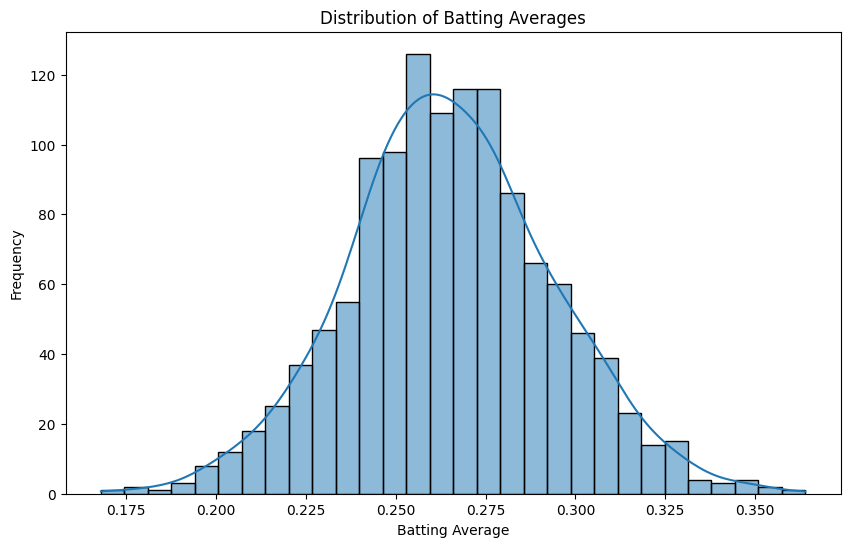

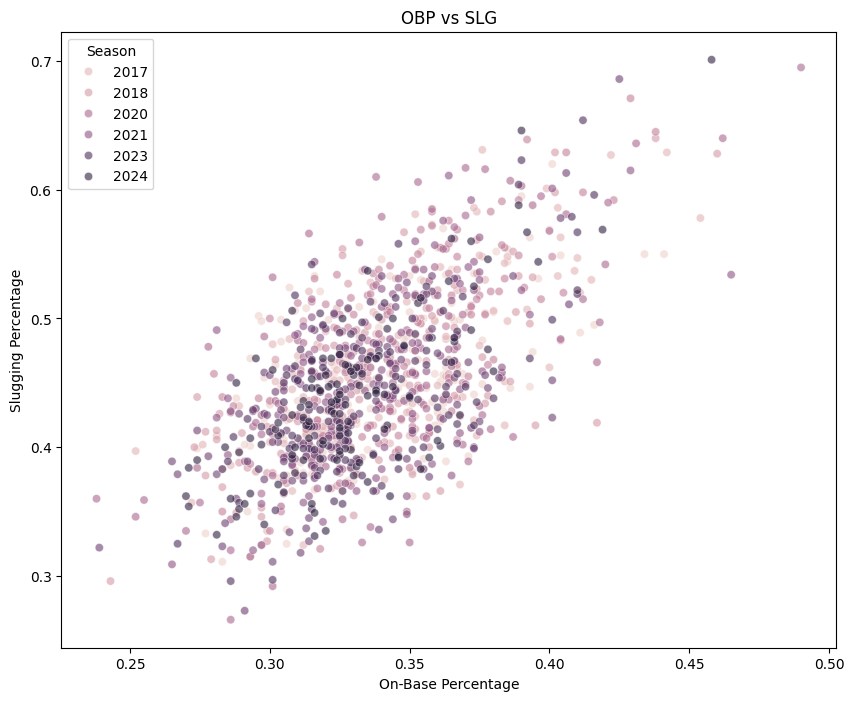

In [13]:
# 3. Basic Visualizations

# Distribution of batting averages
plt.figure(figsize=(10, 6))
sns.histplot(batting_data['AVG'], bins=30, kde=True)
plt.title('Distribution of Batting Averages')
plt.xlabel('Batting Average')
plt.ylabel('Frequency')
plt.show()

# Correlation between OBP and SLG
plt.figure(figsize=(10, 8))
sns.scatterplot(x='OBP', y='SLG', data=batting_data, alpha=0.6, hue='Season')
plt.title('OBP vs SLG')
plt.xlabel('On-Base Percentage')
plt.ylabel('Slugging Percentage')
plt.show()

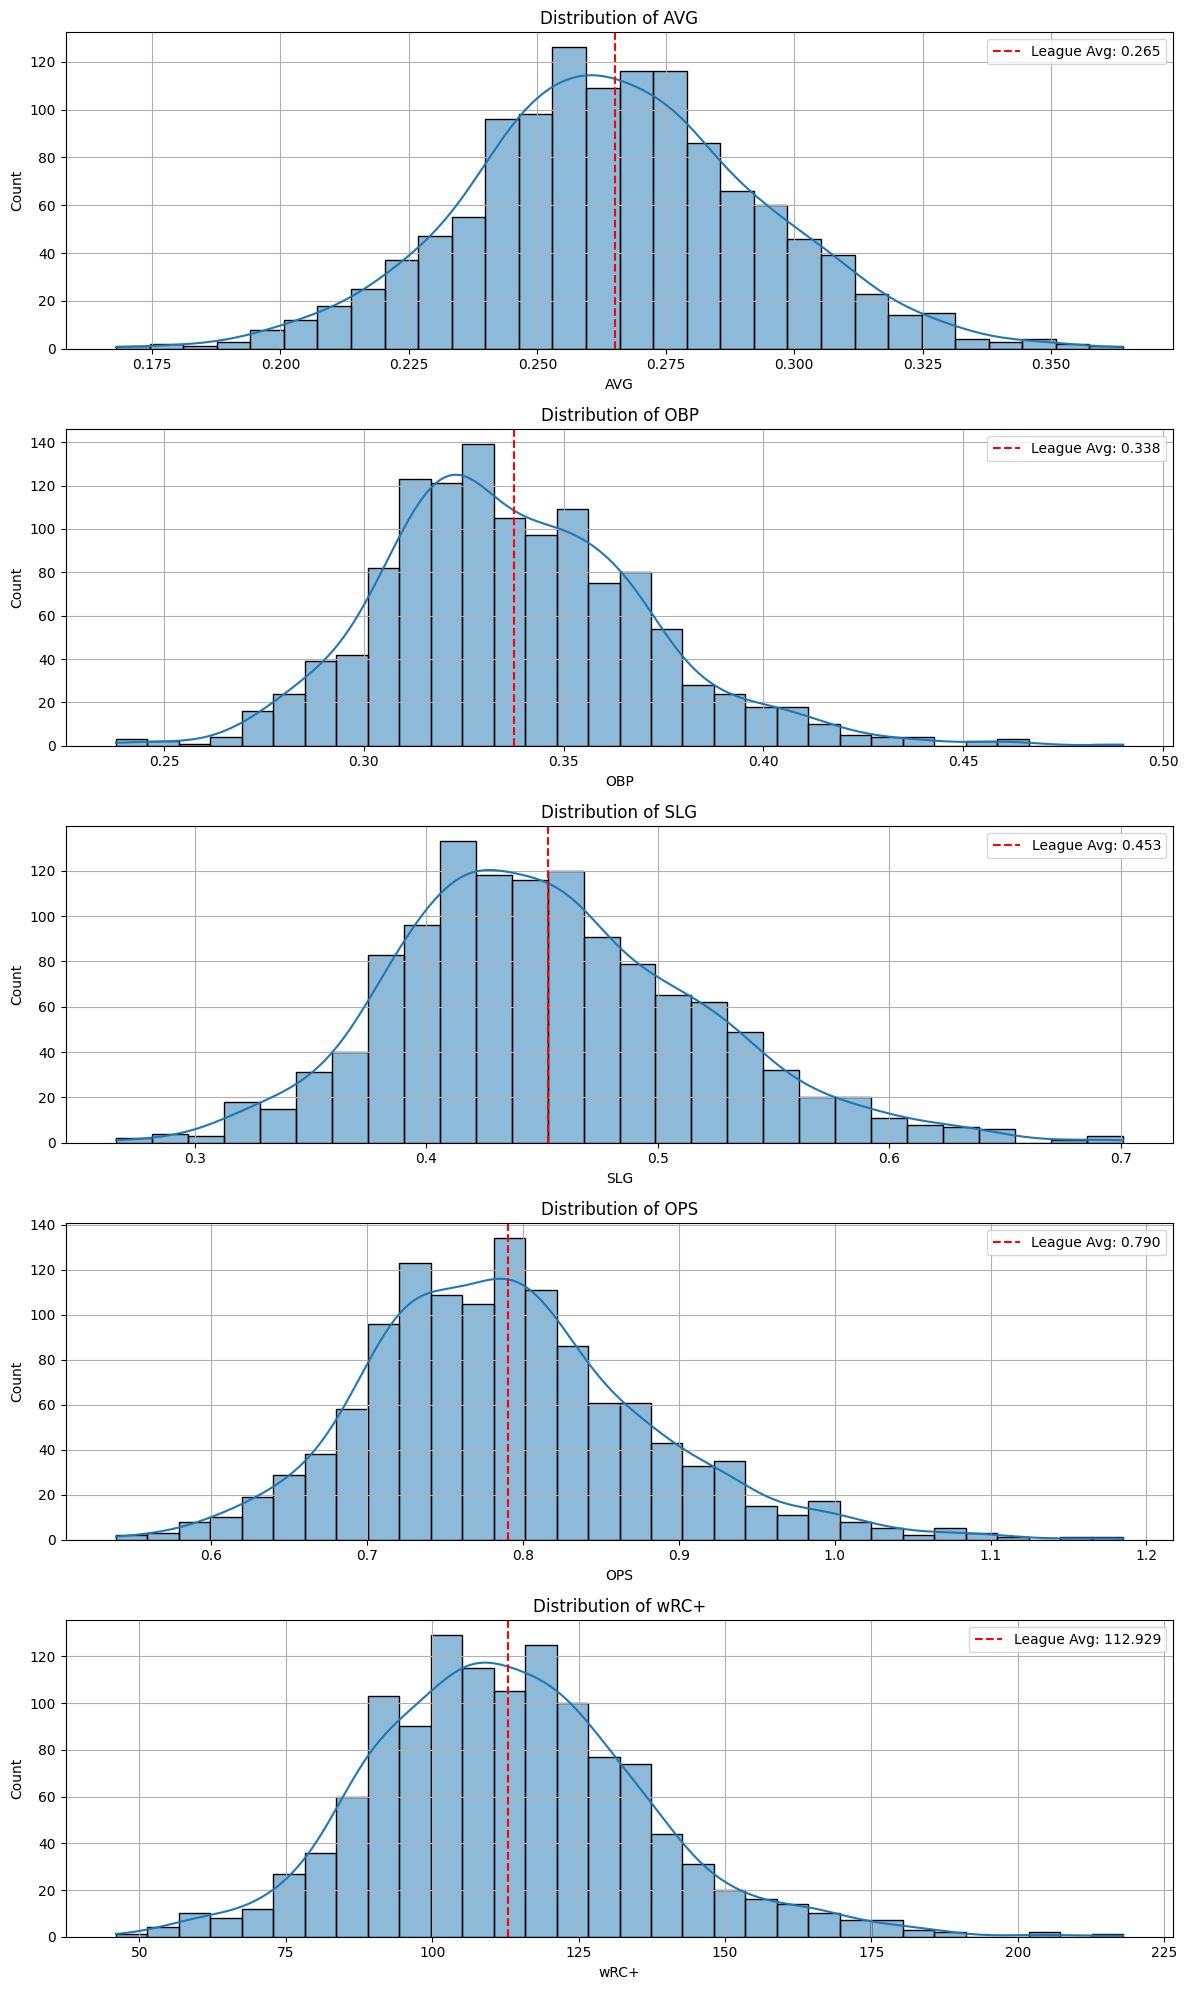

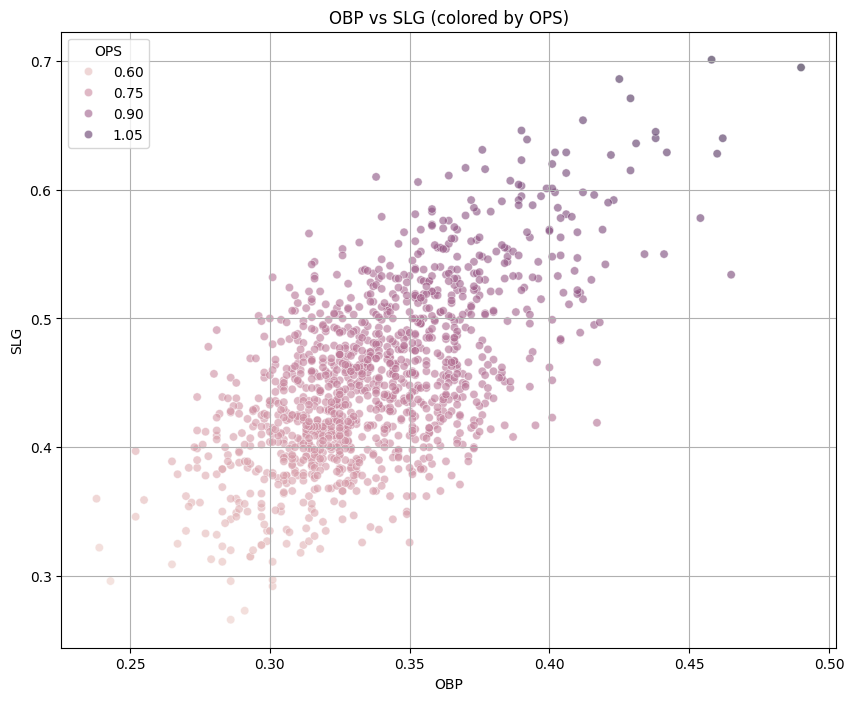

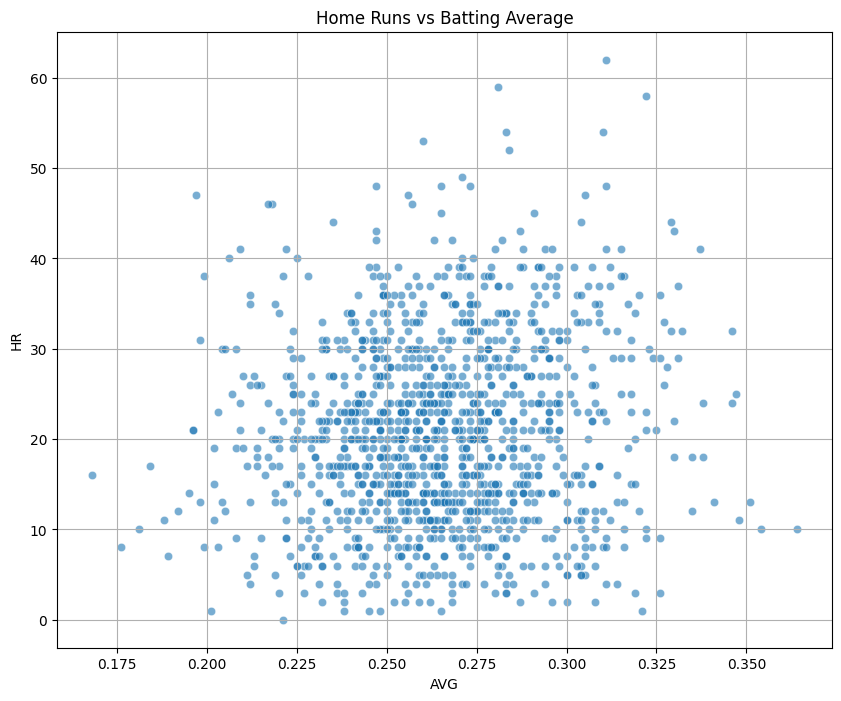

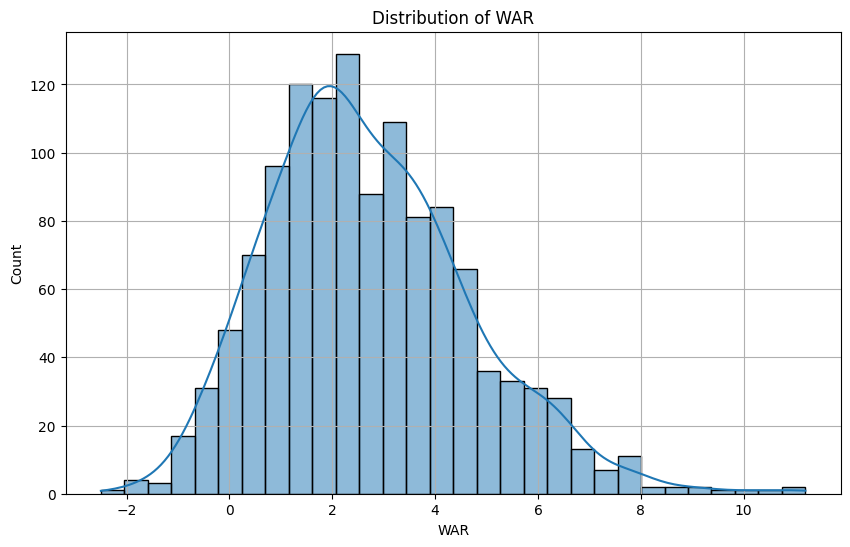

In [14]:
# Batting Data Visualizations
# Distribution of key batting metrics
key_batting_metrics = ['AVG', 'OBP', 'SLG', 'OPS', 'wRC+']
metrics_to_plot = [col for col in key_batting_metrics if col in batting_data.columns]

# Create a multi-plot figure for batting metrics distributions
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 4 * len(metrics_to_plot)))
if len(metrics_to_plot) == 1:
    axes = [axes]

for i, metric in enumerate(metrics_to_plot):
    sns.histplot(batting_data[metric].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].grid(True)
    # Add vertical line for league average
    league_avg = batting_data[metric].mean()
    axes[i].axvline(league_avg, color='r', linestyle='--', label=f'League Avg: {league_avg:.3f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Relationship between OBP, SLG, and OPS
plt.figure(figsize=(10, 8))
sns.scatterplot(x='OBP', y='SLG', data=batting_data, alpha=0.6, hue='OPS')
plt.title('OBP vs SLG (colored by OPS)')
plt.grid(True)
plt.show()

# Home Runs vs Batting Average
plt.figure(figsize=(10, 8))
sns.scatterplot(x='AVG', y='HR', data=batting_data, alpha=0.6)
plt.title('Home Runs vs Batting Average')
plt.grid(True)
plt.show()

# WAR distribution
plt.figure(figsize=(10, 6))
sns.histplot(batting_data['WAR'].dropna(), kde=True, bins=30)
plt.title('Distribution of WAR')
plt.grid(True)
plt.show()

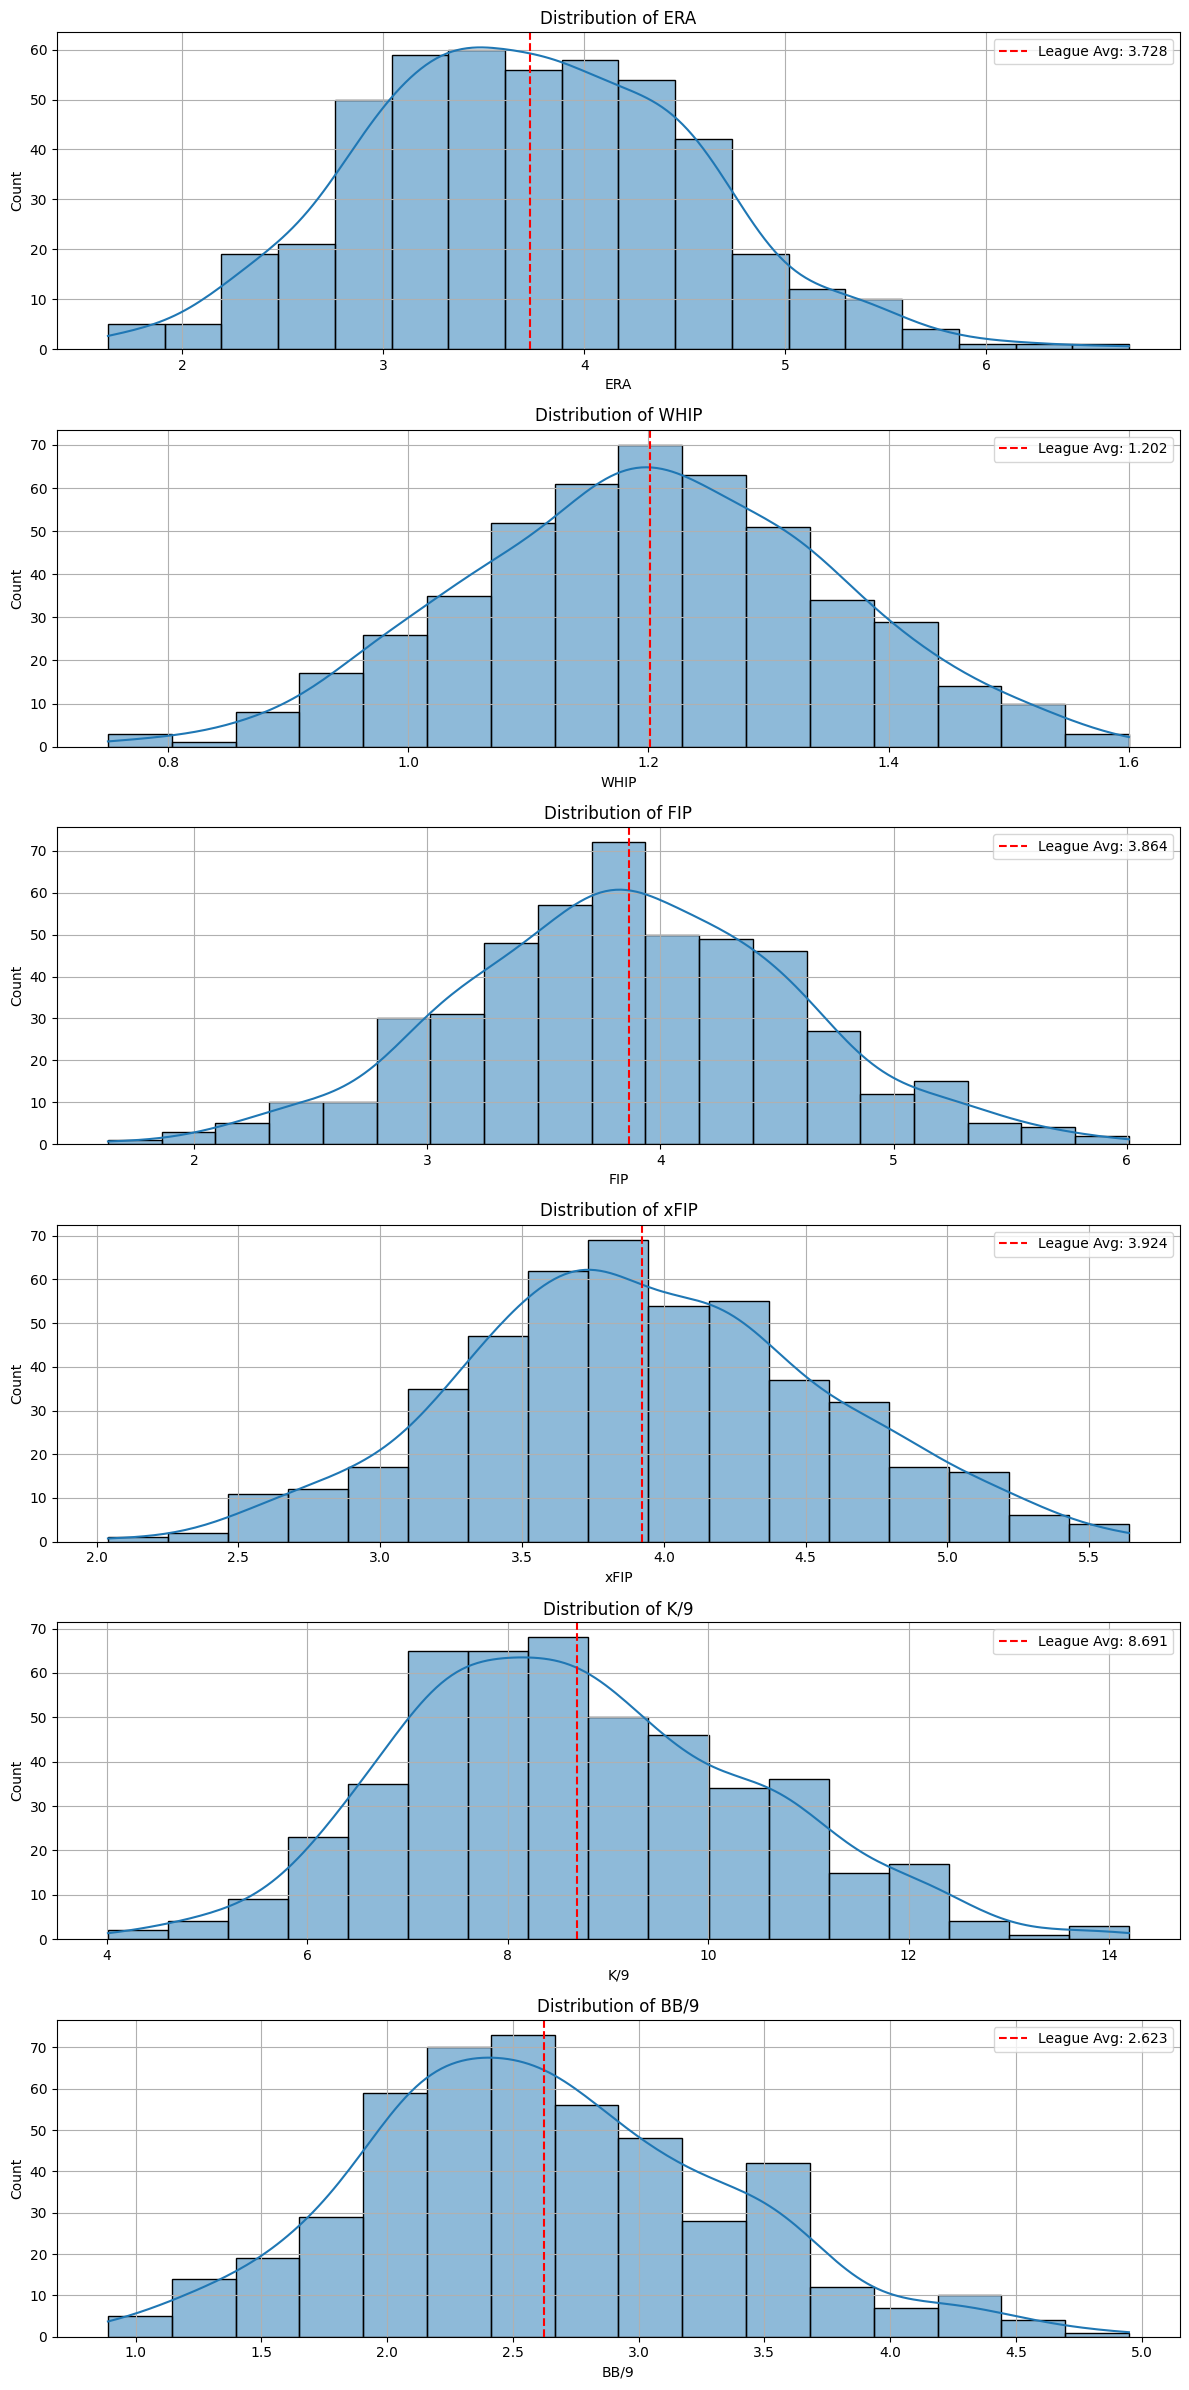

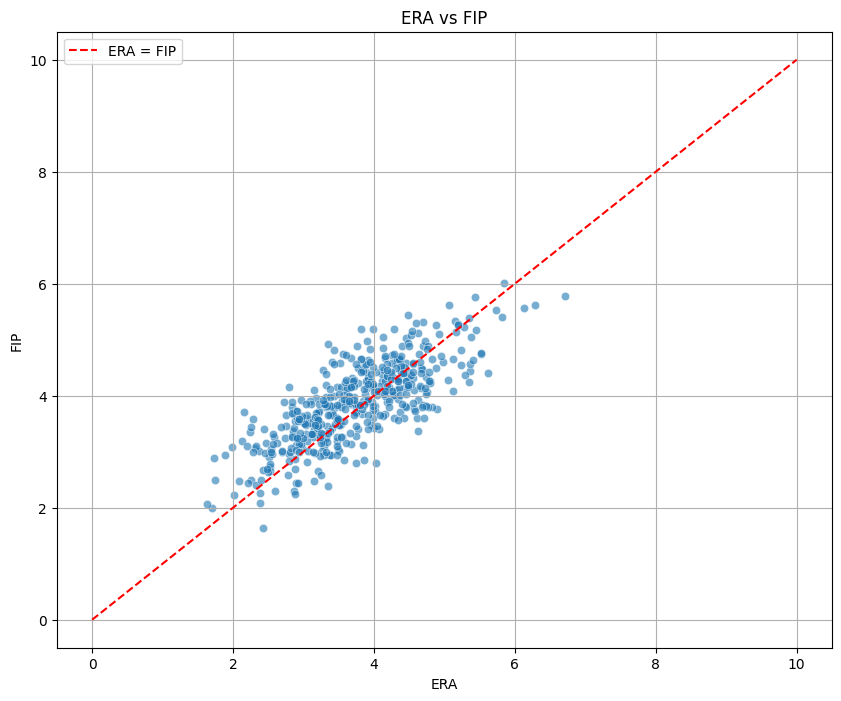

In [15]:
# Pitching Data Visualizations
# Distribution of key pitching metrics
key_pitching_metrics = ['ERA', 'WHIP', 'FIP', 'xFIP', 'K/9', 'BB/9']
metrics_to_plot = [col for col in key_pitching_metrics if col in pitching_data.columns]

# Create a multi-plot figure for pitching metrics distributions
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(12, 4 * len(metrics_to_plot)))
if len(metrics_to_plot) == 1:
    axes = [axes]

for i, metric in enumerate(metrics_to_plot):
    sns.histplot(pitching_data[metric].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].grid(True)
    # Add vertical line for league average
    league_avg = pitching_data[metric].mean()
    axes[i].axvline(league_avg, color='r', linestyle='--', label=f'League Avg: {league_avg:.3f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Relationship between ERA and FIP
plt.figure(figsize=(10, 8))
sns.scatterplot(x='ERA', y='FIP', data=pitching_data, alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--', label='ERA = FIP')
plt.title('ERA vs FIP')
plt.legend()
plt.grid(True)
plt.show()

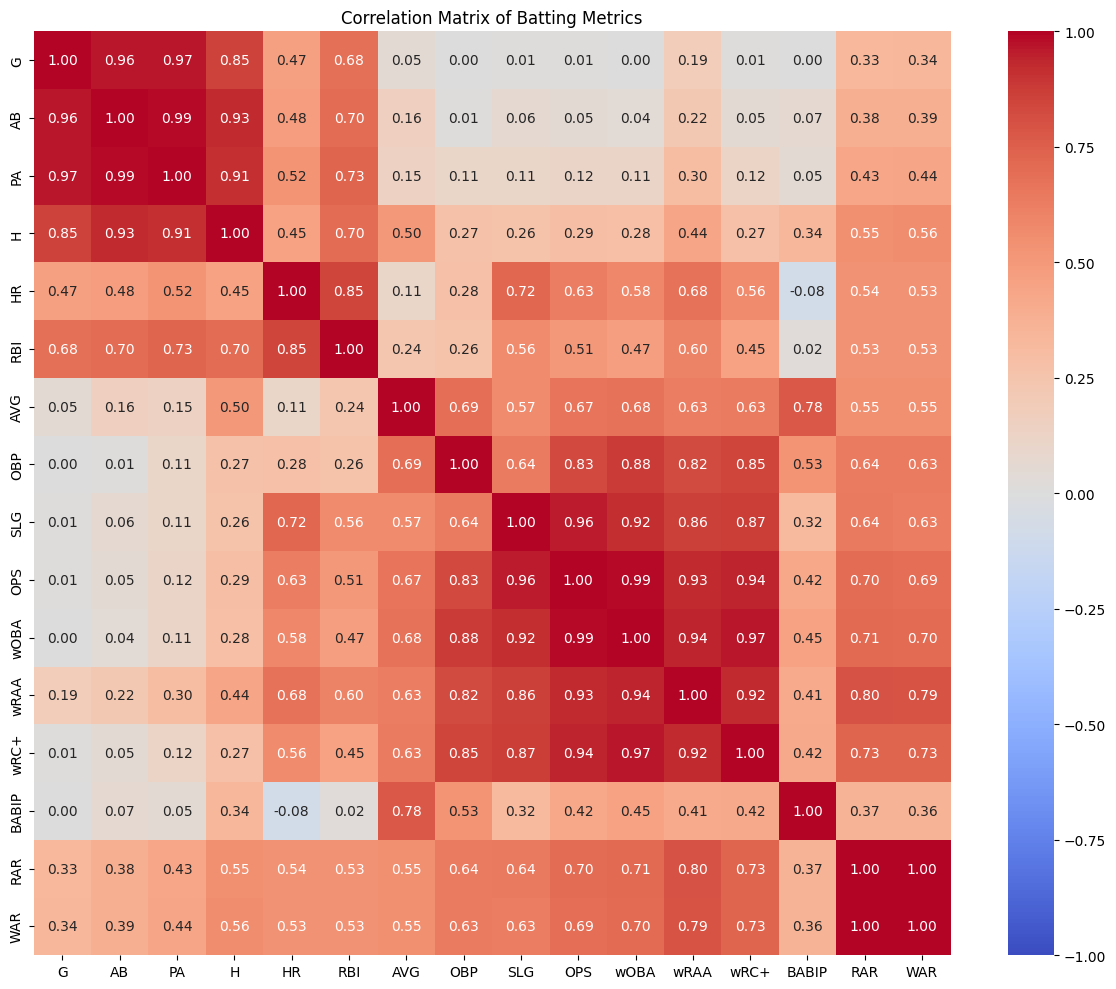


Metrics most correlated with OPS:
OPS      1.000000
wOBA     0.989802
SLG      0.959853
wRC+     0.944494
wRAA     0.927168
OBP      0.828225
RAR      0.700055
WAR      0.690664
AVG      0.667125
HR       0.626199
RBI      0.506229
BABIP    0.424053
H        0.289408
PA       0.116863
AB       0.052193
G        0.010560
Name: OPS, dtype: float64

Metrics most correlated with WAR:
WAR      1.000000
RAR      0.999053
wRAA     0.794664
wRC+     0.727166
wOBA     0.704760
OPS      0.690664
OBP      0.633476
SLG      0.632172
H        0.557053
AVG      0.548470
HR       0.533943
RBI      0.533673
PA       0.440084
AB       0.389574
BABIP    0.363548
G        0.342194
Name: WAR, dtype: float64


In [16]:
# Correlation Analysis
# Select numeric columns (excluding some ID-like columns)
num_cols = batting_data.select_dtypes(include=['number']).columns.tolist()
exclude_cols = ['Season', 'Age']
corr_cols = [col for col in num_cols if col not in exclude_cols]

if len(corr_cols) > 1:
    corr_matrix = batting_data[corr_cols].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Batting Metrics')
    plt.tight_layout()
    plt.show()
    
    # Print metrics most correlated with OPS and WAR
    if 'OPS' in corr_cols:
        ops_corr = corr_matrix['OPS'].sort_values(ascending=False)
        print("\nMetrics most correlated with OPS:")
        print(ops_corr)
    
    if 'WAR' in corr_cols:
        war_corr = corr_matrix['WAR'].sort_values(ascending=False)
        print("\nMetrics most correlated with WAR:")
        print(war_corr)


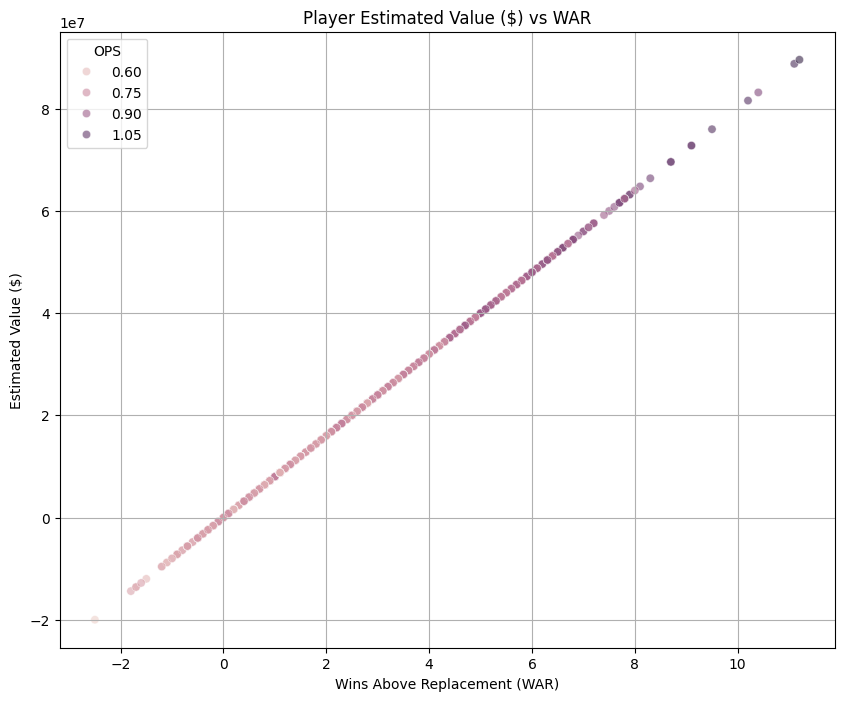

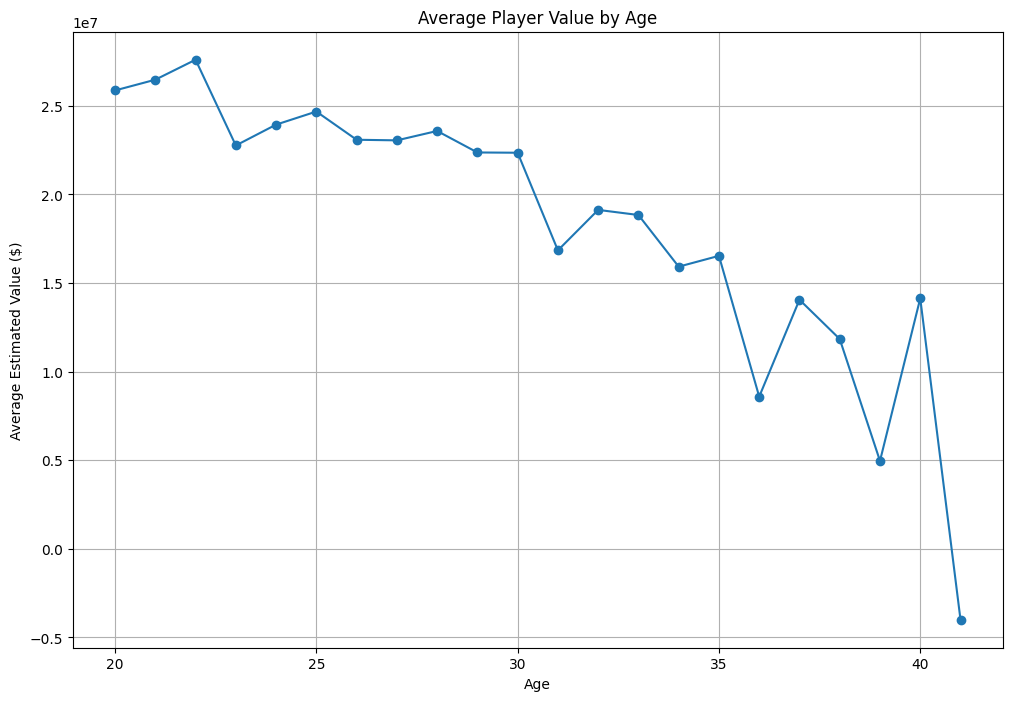

In [17]:
# Business Value Analysis for Batters
batting_data['EstValue'] = batting_data['WAR'] * 8000000  # Using an arbitrary $8M per WAR scale

# Plot WAR vs Estimated Value
plt.figure(figsize=(10, 8))
sns.scatterplot(x='WAR', y='EstValue', data=batting_data, alpha=0.6, hue='OPS')
plt.title('Player Estimated Value ($) vs WAR')
plt.xlabel('Wins Above Replacement (WAR)')
plt.ylabel('Estimated Value ($)')
plt.grid(True)
plt.show()

# Age vs Value Analysis
avg_value_by_age = batting_data.groupby('Age')['EstValue'].mean().reset_index()
plt.figure(figsize=(12, 8))
plt.plot(avg_value_by_age['Age'], avg_value_by_age['EstValue'], 'o-')
plt.title('Average Player Value by Age')
plt.xlabel('Age')
plt.ylabel('Average Estimated Value ($)')
plt.grid(True)
plt.show()

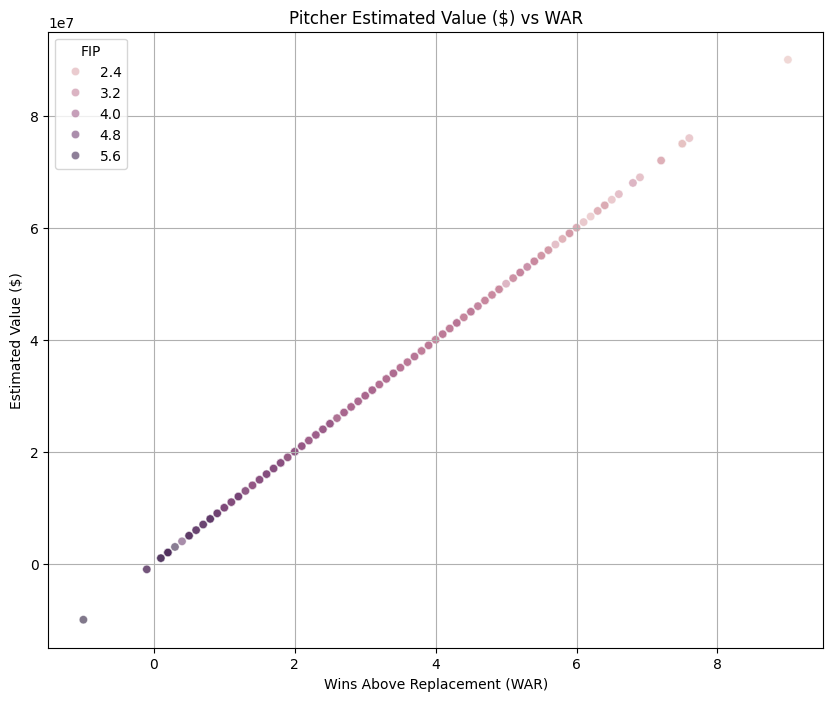

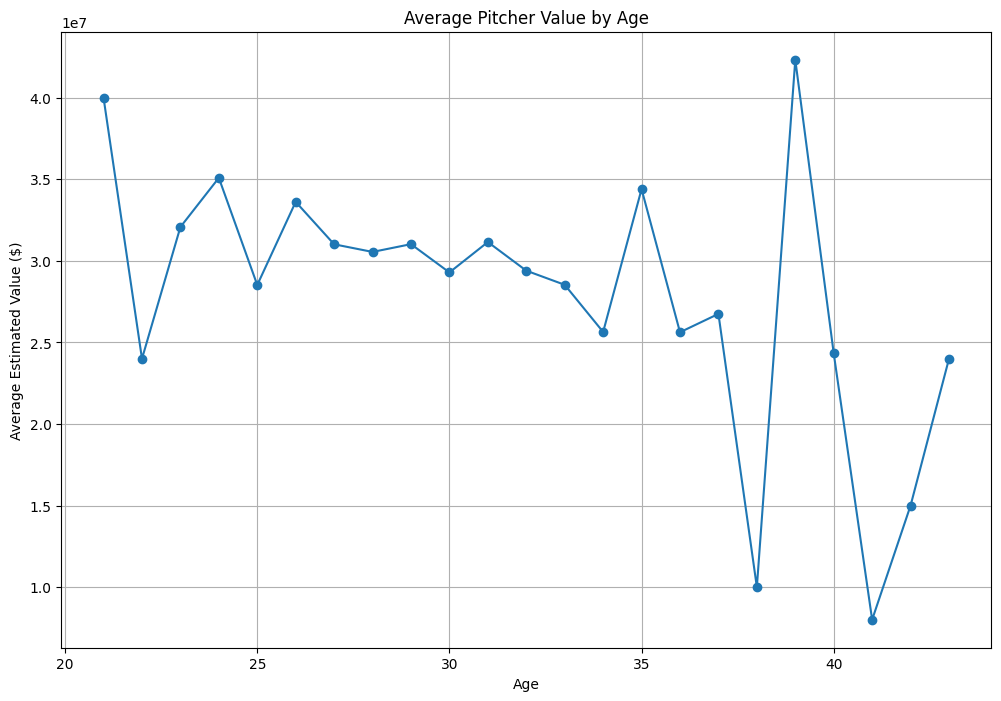

In [18]:
# Business Value Analysis for Pitchers
pitching_data['EstValue'] = pitching_data['WAR'] * 10000000

# Plot WAR vs Estimated Value for pitchers
plt.figure(figsize=(10, 8))
sns.scatterplot(x='WAR', y='EstValue', data=pitching_data, alpha=0.6, hue='FIP')
plt.title('Pitcher Estimated Value ($) vs WAR')
plt.xlabel('Wins Above Replacement (WAR)')
plt.ylabel('Estimated Value ($)')
plt.grid(True)
plt.show()

# Age vs Value Analysis for pitchers
avg_value_by_age = pitching_data.groupby('Age')['EstValue'].mean().reset_index()
plt.figure(figsize=(12, 8))
plt.plot(avg_value_by_age['Age'], avg_value_by_age['EstValue'], 'o-')
plt.title('Average Pitcher Value by Age')
plt.xlabel('Age')
plt.ylabel('Average Estimated Value ($)')
plt.grid(True)
plt.show()

In [19]:
pitching_data.loc[pitching_data['EstValue'].idxmax()]

Season              2018
Name        Jacob deGrom
Team                 NYM
Age                   30
G                     32
IP                 217.0
ERA                  1.7
WHIP                0.91
FIP                 1.99
xFIP                 2.6
SO                   269
BB                    46
K/9                11.16
BB/9                1.91
BABIP              0.281
RAR                 75.8
WAR                  9.0
Dollars            $72.3
H                    152
ER                    41
EstValue      90000000.0
Name: 132, dtype: object

In [20]:
pitching_data[pitching_data['Age'] == 39]

,Season,Name,Team,Age,G,IP,ERA,WHIP,FIP,xFIP,...,BB,K/9,BB/9,BABIP,RAR,WAR,Dollars,H,ER,EstValue
307,2021,Adam Wainwright,STL,39,32,206.1,3.05,1.06,3.66,3.87,...,50,7.59,2.18,0.256,37.9,3.9,$31.2,168,70,39000000.0
332,2022,Justin Verlander,HOU,39,28,175.0,1.75,0.83,2.49,3.23,...,29,9.51,1.49,0.240,52.1,6.1,$48.5,116,34,61000000.0
404,2023,Charlie Morton,ATL,39,30,163.1,3.64,1.43,3.87,4.27,...,83,10.08,4.57,0.321,26.5,2.7,$21.2,150,66,27000000.0


The high average estimated pitcher value at age 39 is mainly becaused despite being in the later stages of their careers, these pitchers continue to deliver high performance, as indicated by their WAR-based EstValue. Their ability to remain effective at age 39 suggests they have adapted their pitching approach or maintained peak performance through experience.

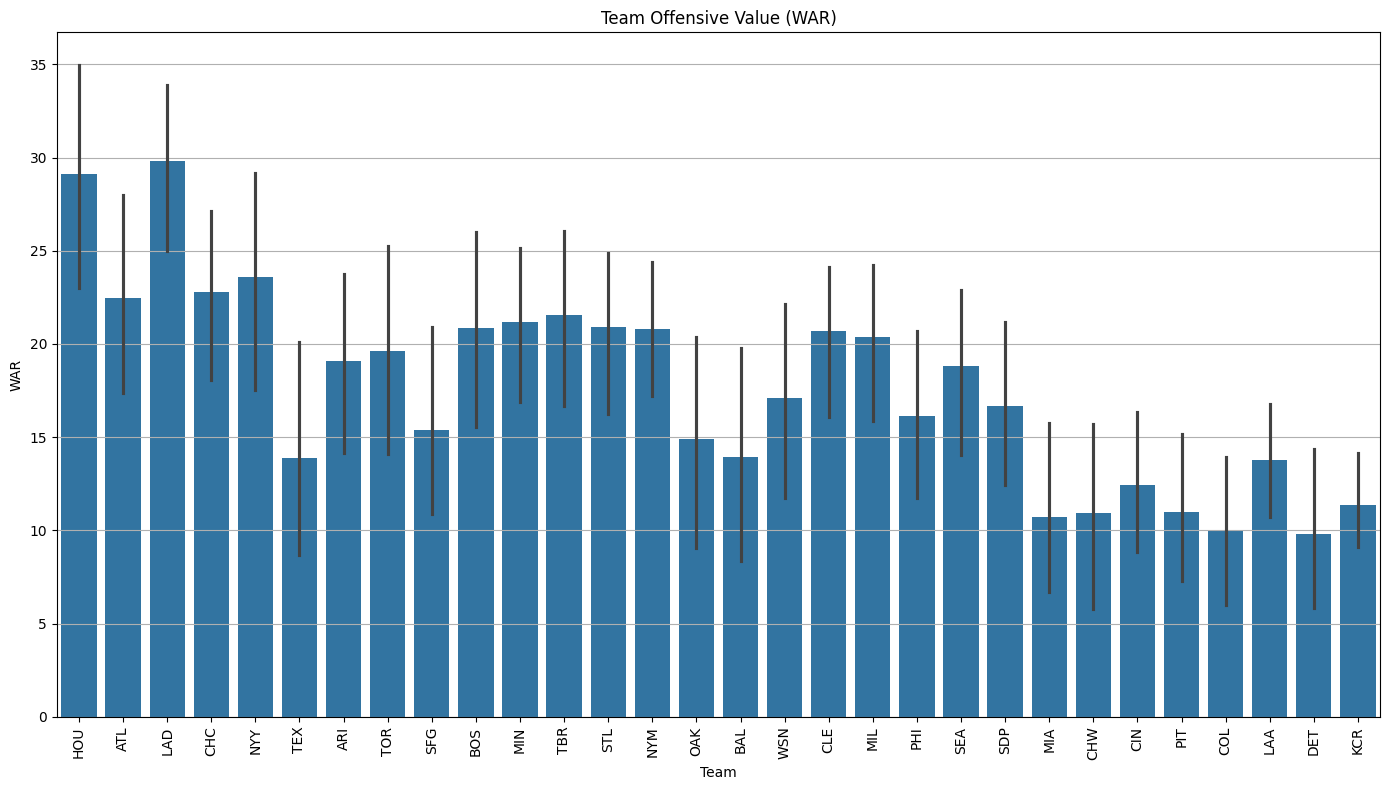

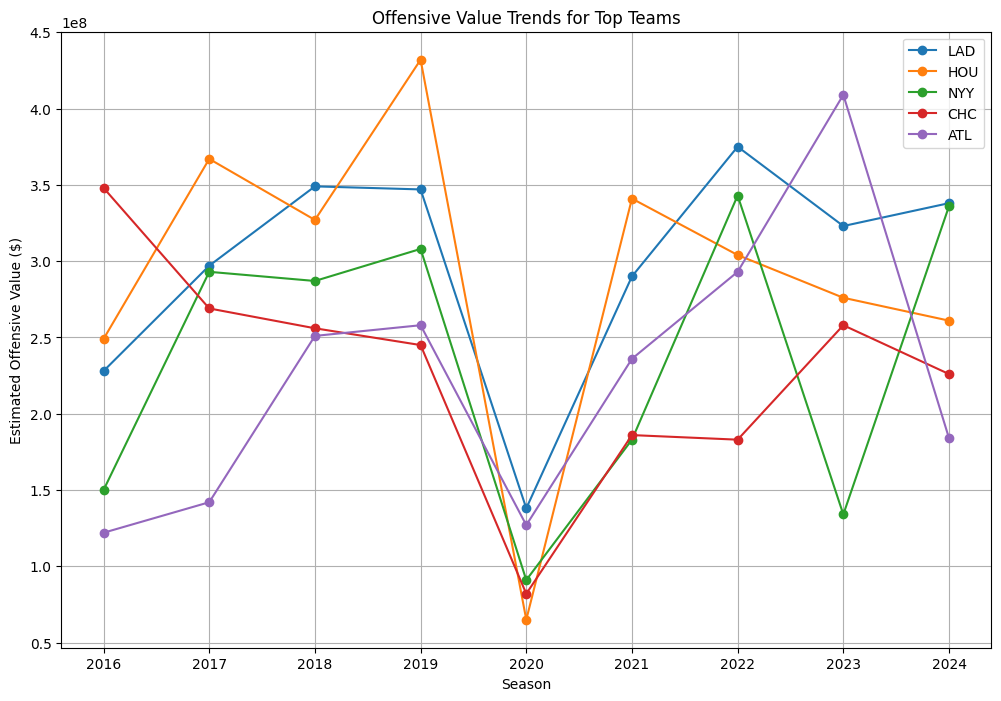

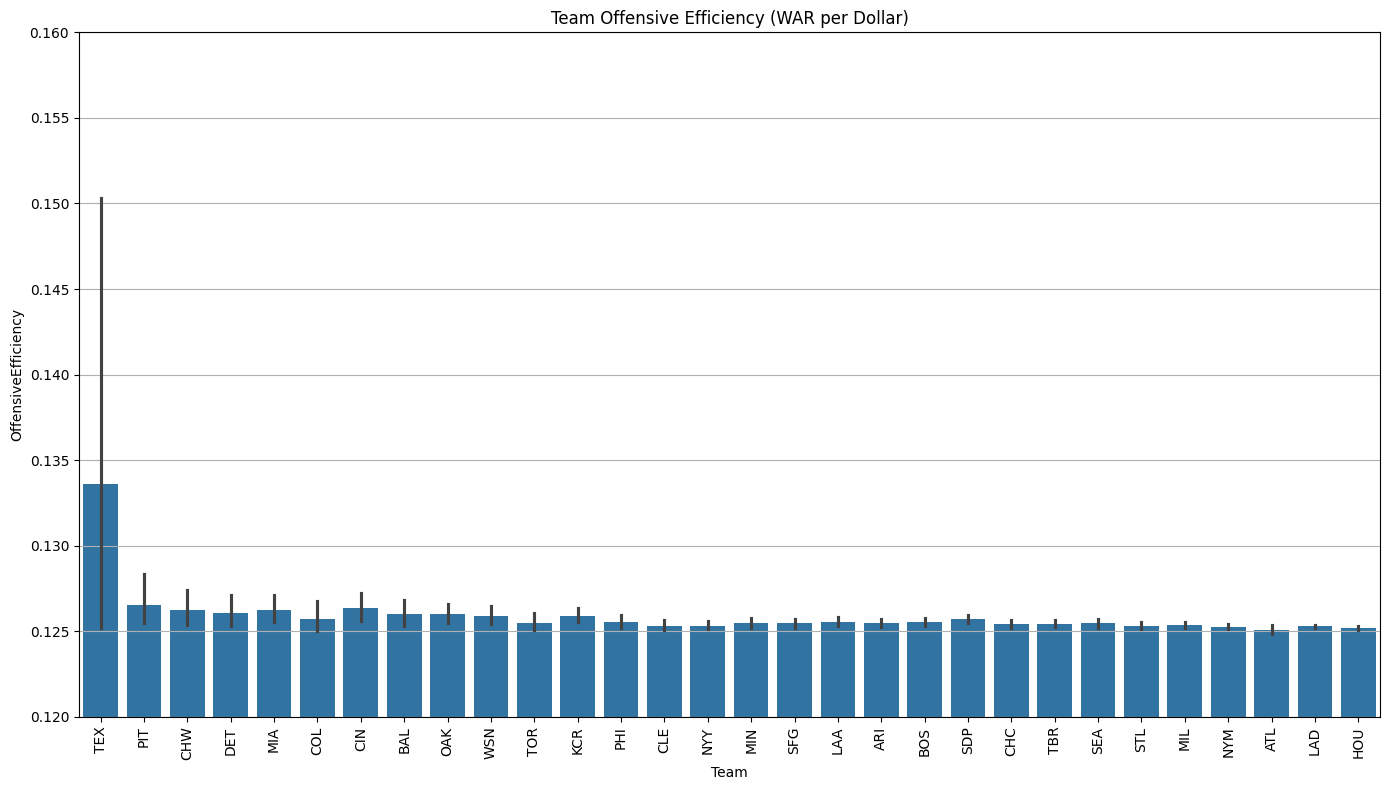

In [26]:
# Team Batting Value Analysis
# Create a market value metric based on team offensive WAR
team_batting_data['OffensiveValue'] = team_batting_data['WAR'] * 10000000
team_batting_data['Dol'] = pd.to_numeric(team_batting_data['Dol'], errors='coerce')

# Compare team offensive metrics
plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='WAR', data=team_batting_data.sort_values('WAR', ascending=False))
plt.title('Team Offensive Value (WAR)')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Team offensive production trends
team_season_trends = team_batting_data.groupby(['Team', 'Season']).agg({
    'OPS': 'mean',
    'wRC+': 'mean',
    'WAR': 'sum',
    'OffensiveValue': 'sum'
}).reset_index()

# Plot offensive value by season for top teams
top_teams = team_batting_data.groupby('Team')['WAR'].mean().nlargest(5).index.tolist()

plt.figure(figsize=(12, 8))
for team in top_teams:
    team_data = team_season_trends[team_season_trends['Team'] == team]
    plt.plot(team_data['Season'], team_data['OffensiveValue'], marker='o', label=team)
plt.title('Offensive Value Trends for Top Teams')
plt.xlabel('Season')
plt.ylabel('Estimated Offensive Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate offensive efficiency (WAR per payroll dollar)
team_batting_data['OffensiveEfficiency'] = team_batting_data['WAR'] / team_batting_data['Dol']

plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='OffensiveEfficiency', data=team_batting_data.sort_values('OffensiveEfficiency', ascending=False))
plt.title('Team Offensive Efficiency (WAR per Dollar)')
plt.xticks(rotation=90)
plt.ylim(0.12, 0.16)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

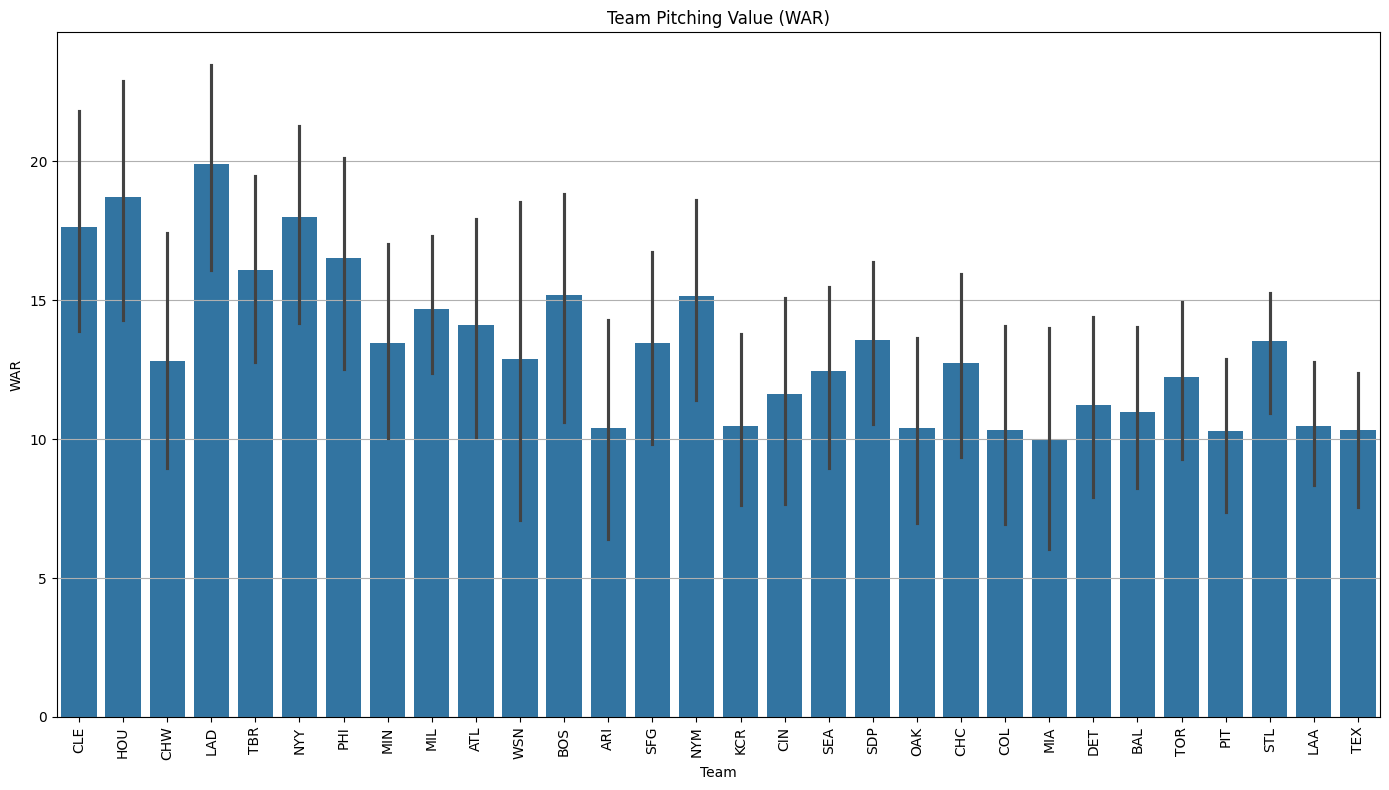

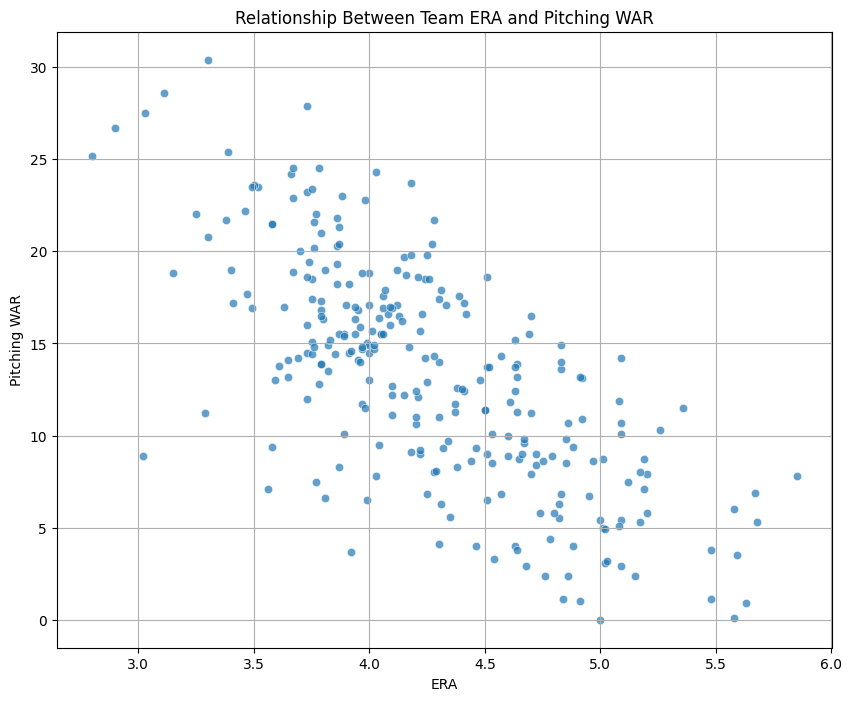

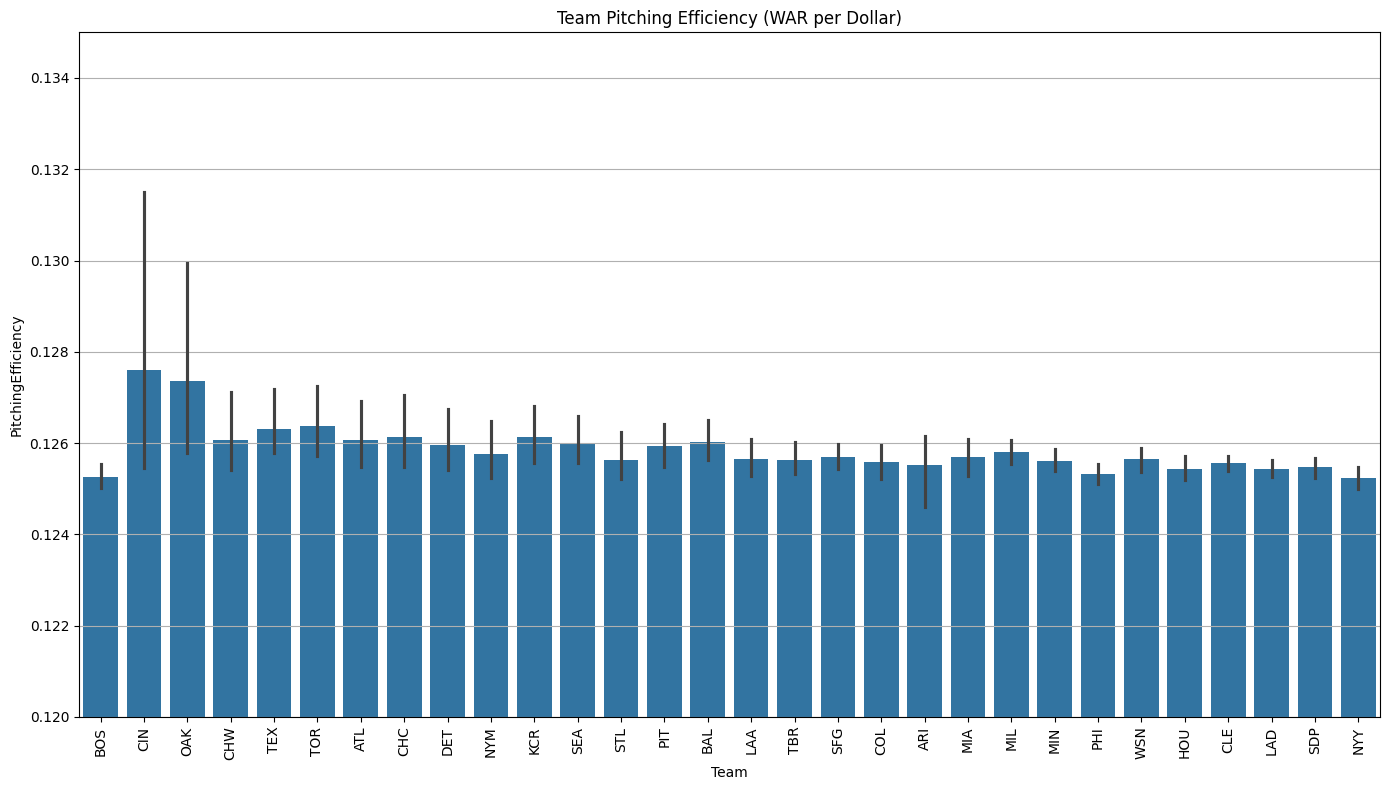

In [30]:
# 2. Team Pitching Value Analysis
# Create a market value metric based on team pitching WAR
team_pitching_data['PitchingValue'] = team_pitching_data['WAR'] * 10000000  # $10M per WAR

# Compare team pitching metrics
plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='WAR', data=team_pitching_data.sort_values('WAR', ascending=False))
plt.title('Team Pitching Value (WAR)')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Relationship between ERA and WAR
plt.figure(figsize=(10, 8))
sns.scatterplot(x='ERA', y='WAR', data=team_pitching_data, alpha=0.7)
plt.title('Relationship Between Team ERA and Pitching WAR')
plt.xlabel('ERA')
plt.ylabel('Pitching WAR')
plt.grid(True)
plt.show()

# Calculate pitching efficiency (WAR per payroll dollar)
team_pitching_data['PitchingEfficiency'] = team_pitching_data['WAR'] / team_pitching_data['Dollars']

plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='PitchingEfficiency', data=team_pitching_data.sort_values('PitchingEfficiency', ascending=False))
plt.title('Team Pitching Efficiency (WAR per Dollar)')
plt.xticks(rotation=90)
plt.ylim(0.12, 0.135)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

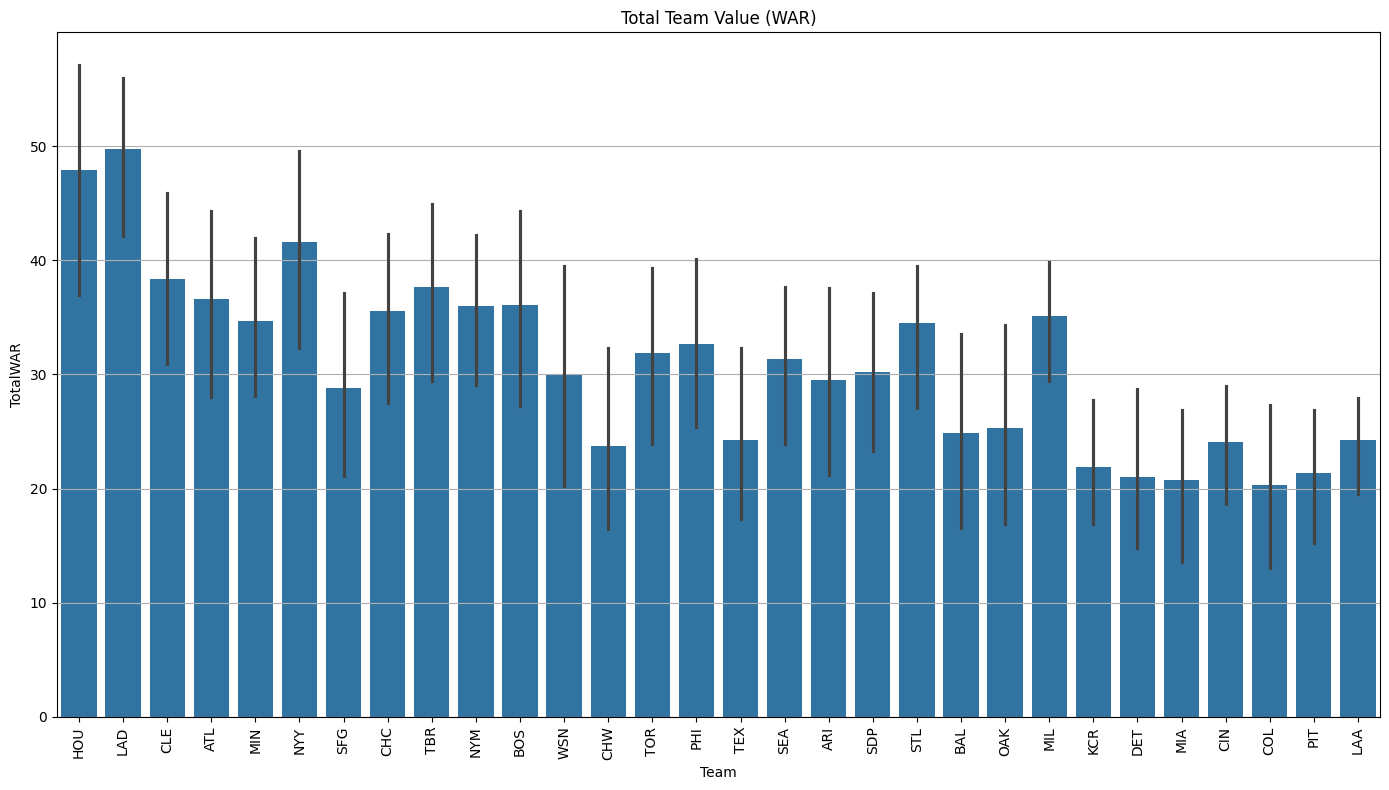

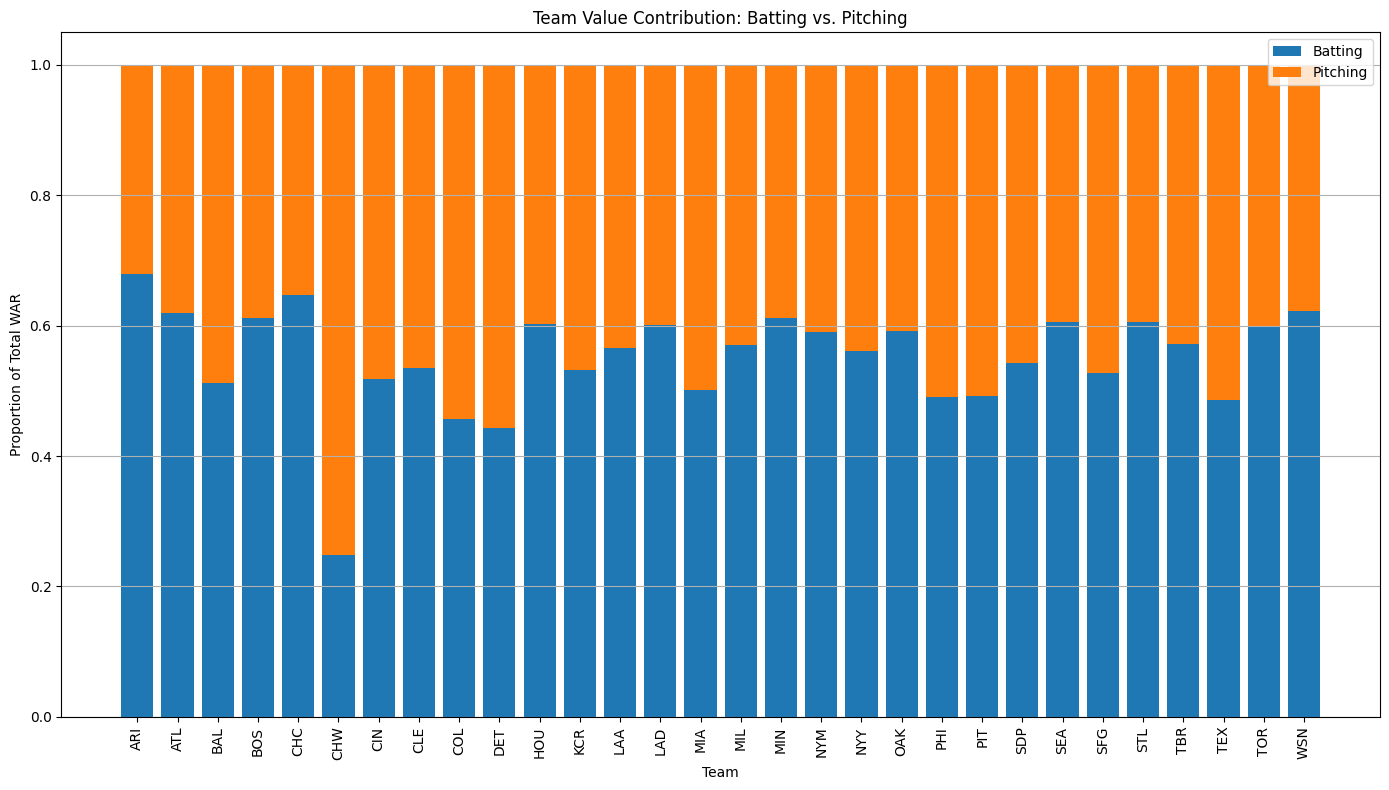

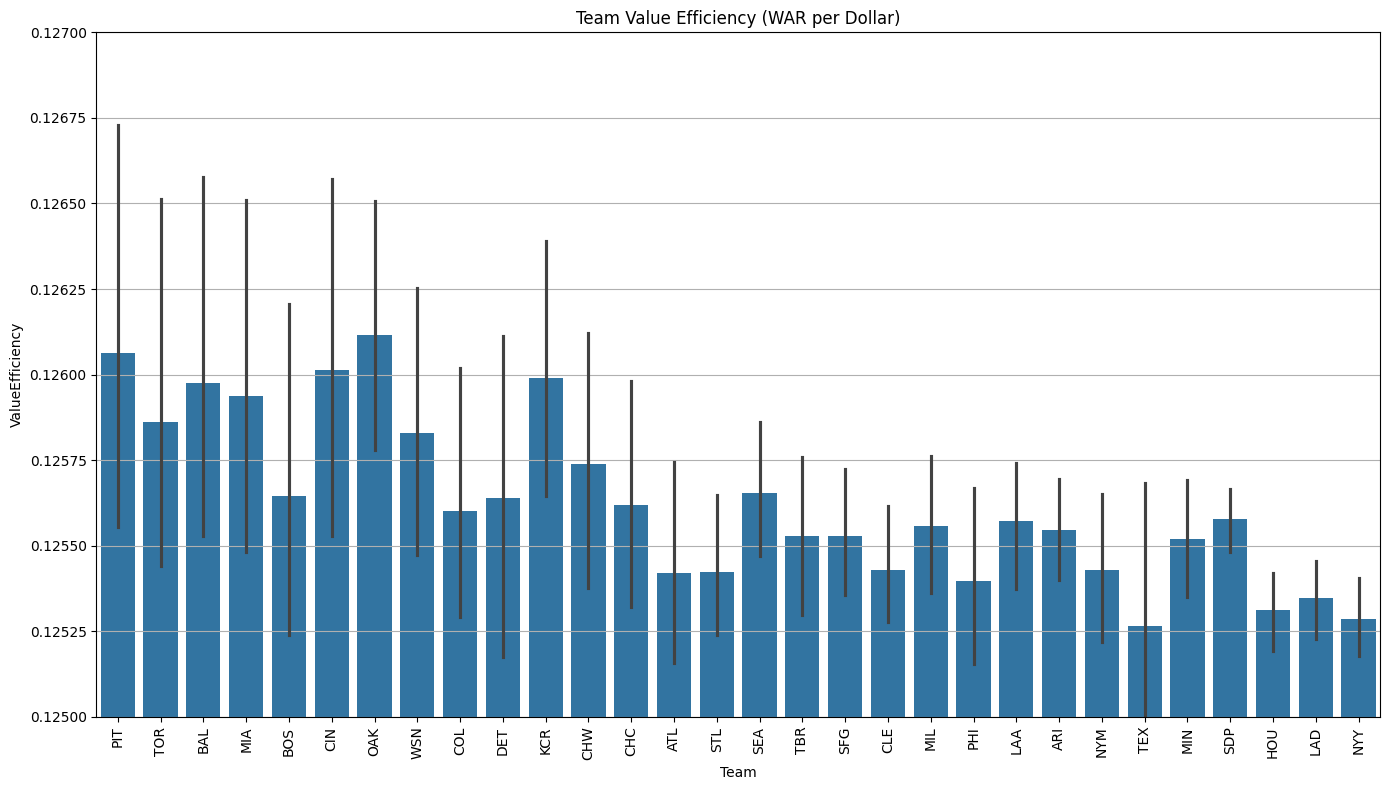

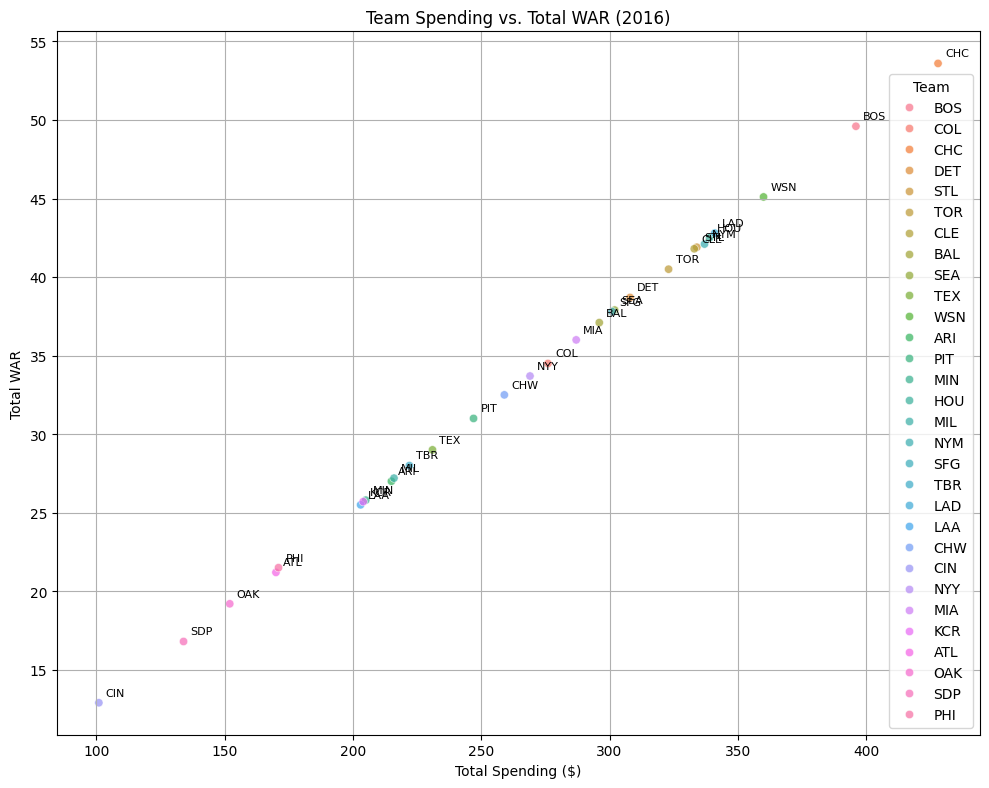

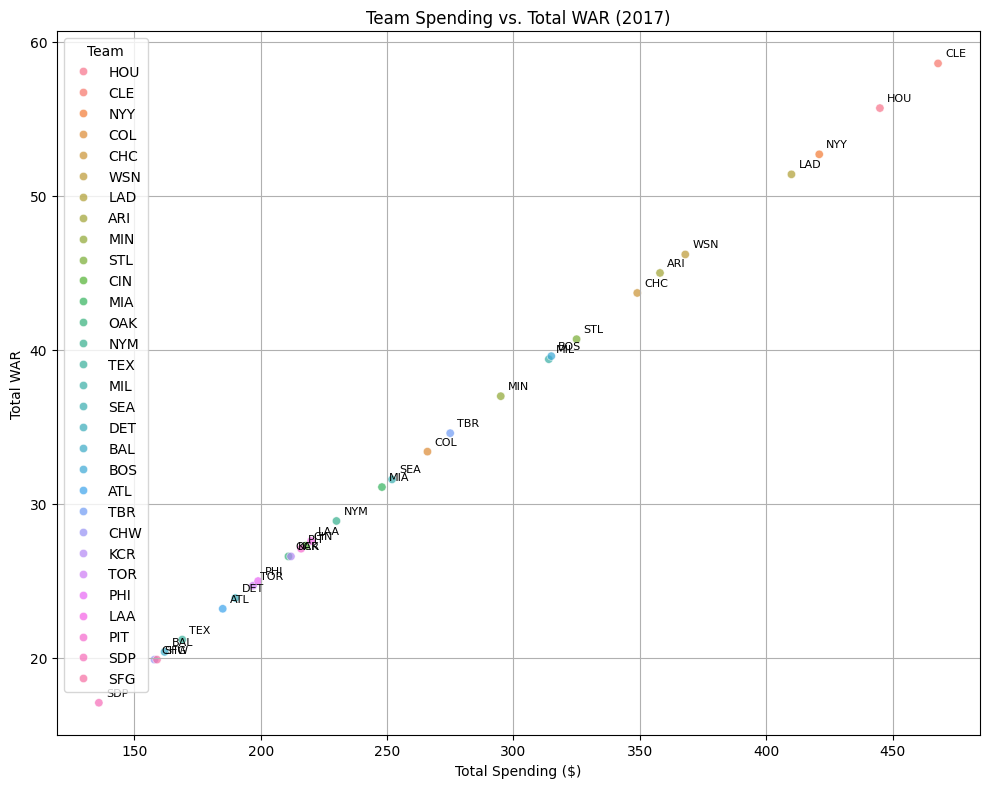

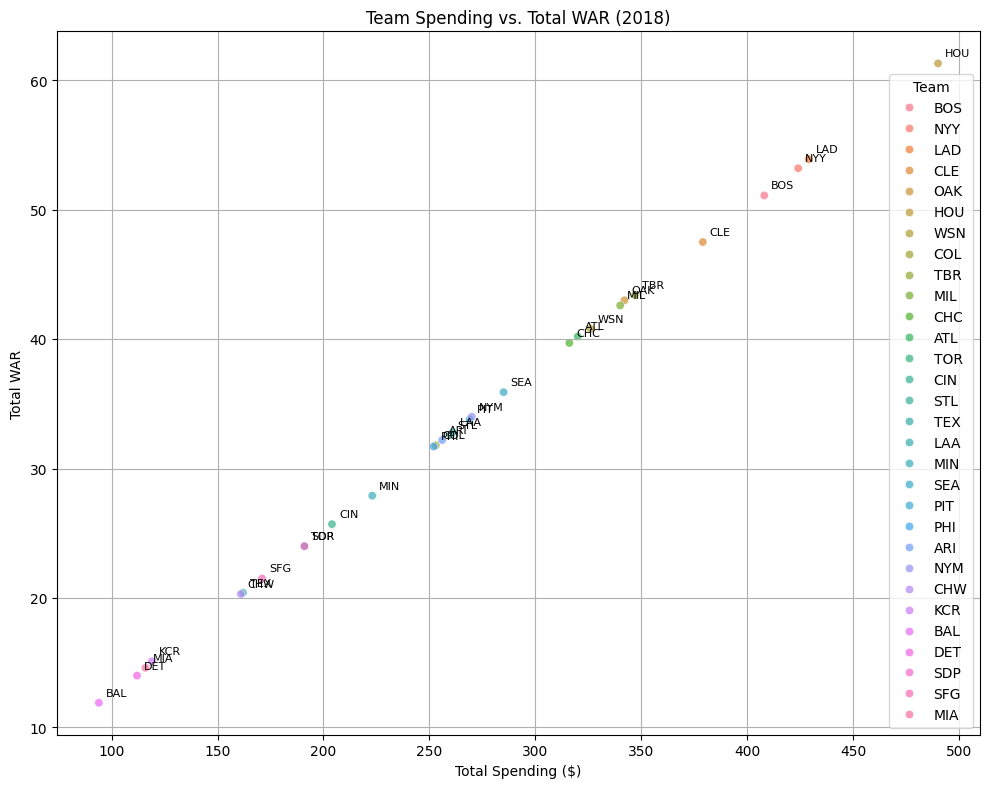

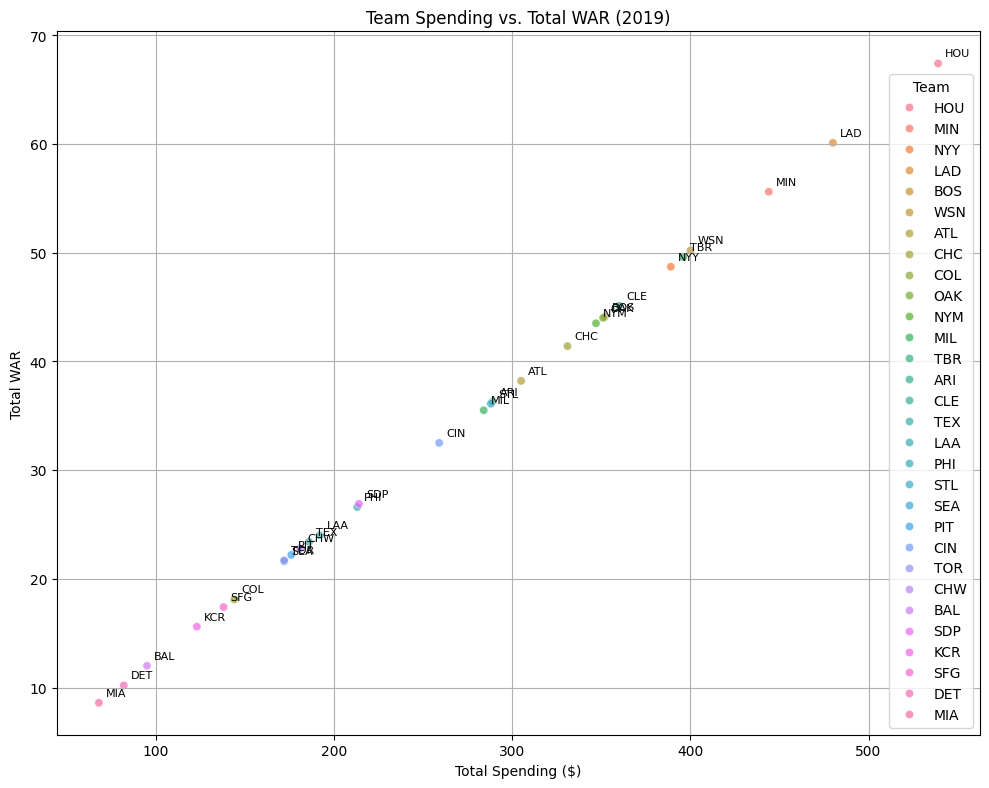

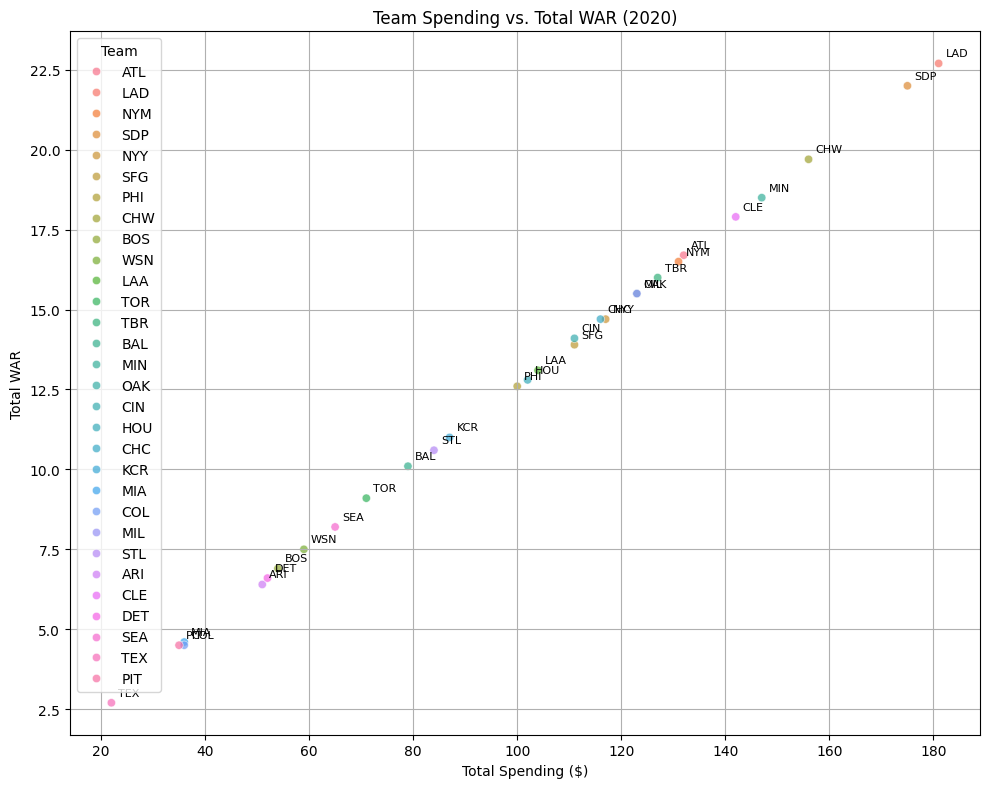

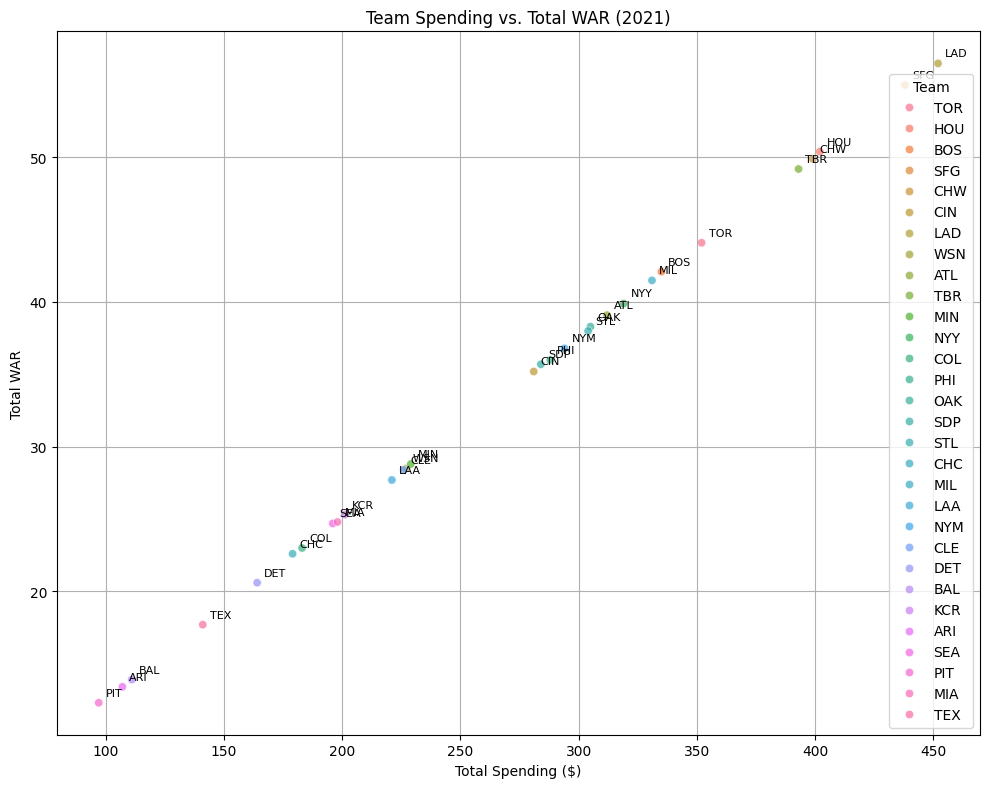

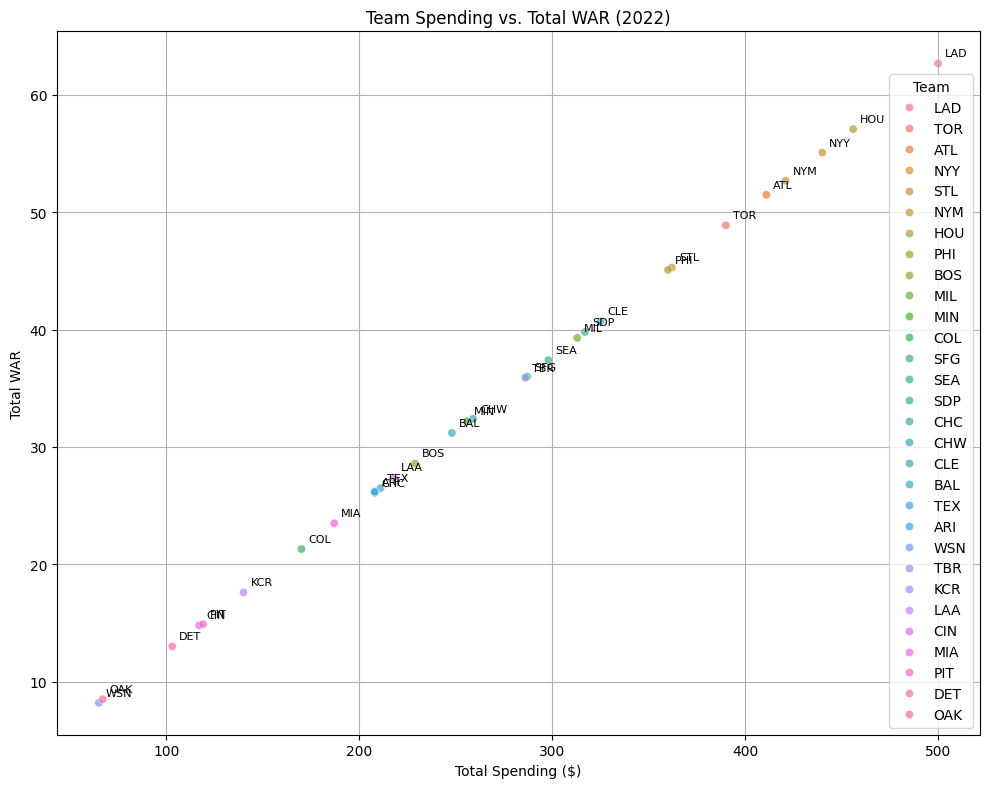

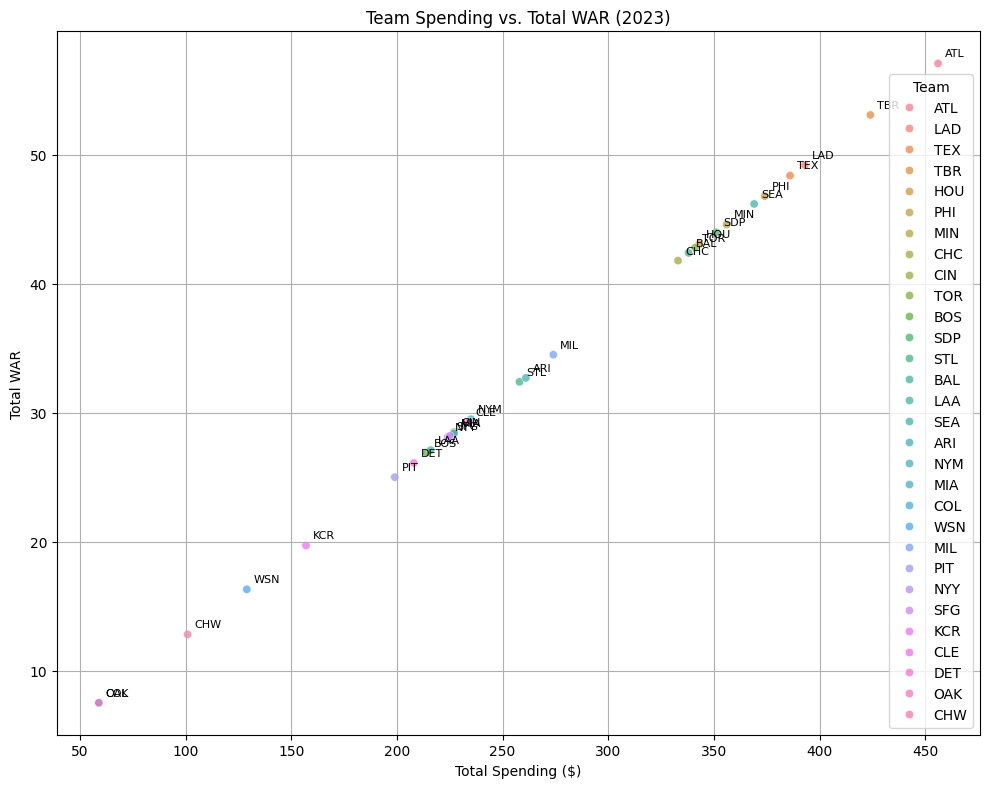

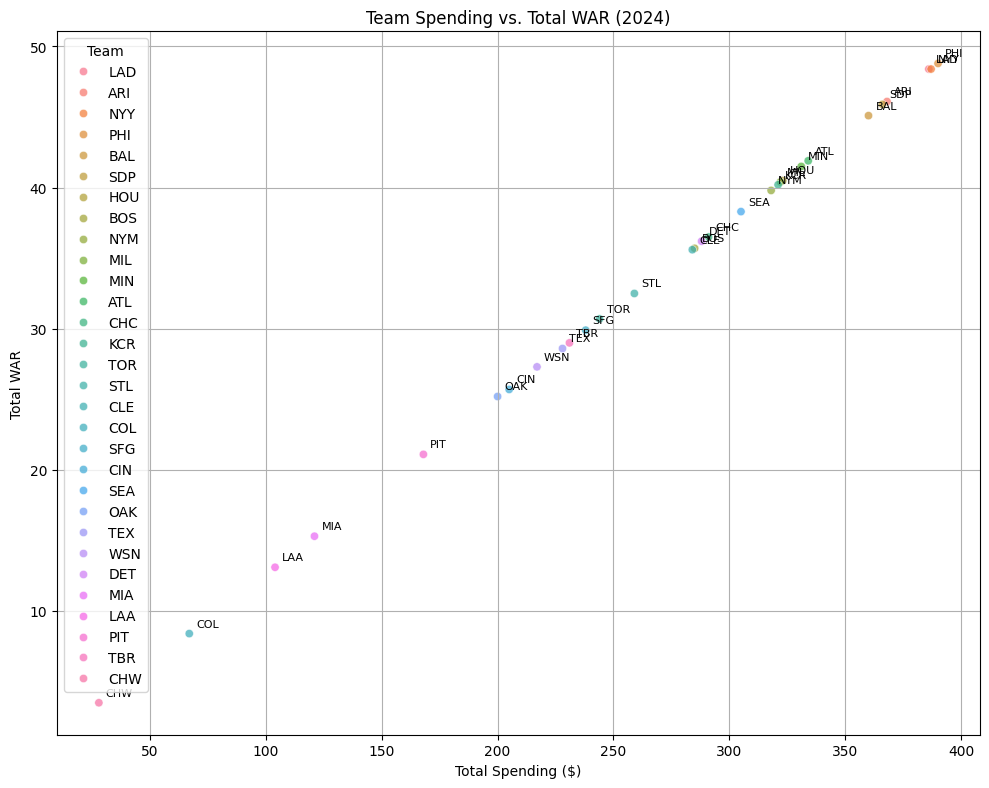

In [36]:
#3. Combined Team Value Analysis
# Get common seasons to merge on and filter data
common_seasons = set(team_batting_data['Season']).intersection(set(team_pitching_data['Season']))
batting_subset = team_batting_data[team_batting_data['Season'].isin(common_seasons)]
pitching_subset = team_pitching_data[team_pitching_data['Season'].isin(common_seasons)]

# Merge batting and pitching data on Team and Season
merged_team_data = pd.merge(
    batting_subset,
    pitching_subset,
    on=['Team', 'Season'],
    suffixes=('_batting', '_pitching')
)

# Calculate total team value
merged_team_data['TotalWAR'] = merged_team_data['WAR_batting'] + merged_team_data['WAR_pitching']
merged_team_data['TotalValue'] = merged_team_data['TotalWAR'] * 10000000  # $10M per WAR

plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='TotalWAR', data=merged_team_data.sort_values('TotalWAR', ascending=False))
plt.title('Total Team Value (WAR)')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Contribution breakdown: batting vs pitching
merged_team_data['BattingContribution'] = merged_team_data['WAR_batting'] / merged_team_data['TotalWAR']
merged_team_data['PitchingContribution'] = merged_team_data['WAR_pitching'] / merged_team_data['TotalWAR']
avg_contribution = merged_team_data.groupby('Team')[['BattingContribution', 'PitchingContribution']].mean().reset_index()

plt.figure(figsize=(14, 8))
ax = plt.subplot(111)
ax.bar(avg_contribution['Team'], avg_contribution['BattingContribution'], label='Batting')
ax.bar(avg_contribution['Team'], avg_contribution['PitchingContribution'], bottom=avg_contribution['BattingContribution'], label='Pitching')
plt.title('Team Value Contribution: Batting vs. Pitching')
plt.xlabel('Team')
plt.ylabel('Proportion of Total WAR')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Value efficiency analysis: total spending vs. total WAR
merged_team_data['TotalSpending'] = merged_team_data['Dol'] + merged_team_data['Dollars']
merged_team_data['ValueEfficiency'] = merged_team_data['TotalWAR'] / merged_team_data['TotalSpending']

plt.figure(figsize=(14, 8))
sns.barplot(x='Team', y='ValueEfficiency', data=merged_team_data.sort_values('ValueEfficiency', ascending=False))
plt.title('Team Value Efficiency (WAR per Dollar)')
plt.xticks(rotation=90)
plt.ylim(0.125, 0.127)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Spending vs. WAR correlation
seasons = sorted(merged_team_data['Season'].unique())
for season in seasons:
    # Filter the merged dataset for the current season
    season_data = merged_team_data[merged_team_data['Season'] == season]
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='TotalSpending', y='TotalWAR', data=season_data, alpha=0.7, hue='Team')
    plt.title(f'Team Spending vs. Total WAR ({season})')
    plt.xlabel('Total Spending ($)')
    plt.ylabel('Total WAR')
    plt.grid(True)
    for i, row in season_data.iterrows():
        plt.annotate(
            row['Team'],
            (row['TotalSpending'], row['TotalWAR']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8
        )
    plt.tight_layout()
    plt.show()